<a href="https://colab.research.google.com/github/Halil3509/Simple-ML-DL-Works/blob/main/part1_multi_vector_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Multi-Vector Image Retrieval: A Deep-Dive Series
## Part 1 — Foundations, Architectures & Comparisons

> *"Before you can build the engine, you need to understand why the pistons fire in a specific order."*

---

**Series Overview:**  
This is Part 1 of a multi-part engineering blog series on building production-grade multi-vector image retrieval systems using [Qdrant](https://qdrant.tech/). Each part builds on the last, but Part 1 is the conceptual foundation — and without it, the code in later parts will feel like cargo-culting.

**Who this is for:**  
You're an ML or backend engineer who has worked with embeddings before. You know what cosine similarity is. You've probably used FAISS or a vector database. But you want to deeply understand *why* different retrieval architectures exist, *when* to use them, and *how* they map to real engineering trade-offs.

**What you'll understand after Part 1:**
- The geometry of single-vector vs. multi-vector representations
- How ColBERT's late interaction mechanism actually works
- What poly-encoders are and where they sit in the design space
- How vector-based image search differs from text retrieval
- How all of these map to concrete Qdrant data structures

---

### 📚 Table of Contents

1. [Setup & Dependencies](#setup)
2. [The Problem: Why One Vector Is Not Always Enough](#problem)
3. [Normal Sentence Embeddings: Single-Vector Retrieval](#single-vector)
4. [Multi-Vector Retrieval: Representing Documents as Sets](#multi-vector)
5. [ColBERT: Late Interaction and Token-Level Matching](#colbert)
6. [Poly-Encoders: Structured Multi-Vector Compression](#poly)
7. [Vector-Based Image Search](#image-search)
8. [Architectural Comparison Deep-Dive](#comparison)
9. [Qdrant: Modeling Each Architecture](#qdrant)
10. [Summary & What's Next](#summary)


---
<a id='setup'></a>
## 1. Setup & Dependencies

We'll use the following libraries throughout this notebook. Install them once:

In [ ]:
# Install all dependencies
!pip install qdrant-client sentence-transformers transformers torch torchvision \
             Pillow numpy pandas matplotlib seaborn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.4/390.4 kB 24.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from PIL import Image
import torch
import warnings
warnings.filterwarnings('ignore')

# Qdrant
from qdrant_client import QdrantClient
from qdrant_client.models import (
    Distance, VectorParams, NamedVector,
    PointStruct, MultiVectorConfig, MultiVectorComparator,
    SearchRequest, SparseVectorParams, SparseIndexParams
)

# Sentence Transformers
from sentence_transformers import SentenceTransformer

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("✅ All dependencies loaded successfully.")

✅ All dependencies loaded successfully.


---
<a id='problem'></a>
## 2. The Problem: Why One Vector Is Not Always Enough

Before we dive into architectures, let's build the right intuition for *why* this problem is hard.

### The Compression Hypothesis

When you encode a sentence like:

> *"The bank by the river was steep and muddy after the rain."*

...into a single 768-dimensional vector, you're performing **extreme lossy compression**. All the semantic richness of every token — *bank* (financial? riverbank?), *steep*, *muddy*, *rain* — gets collapsed into a single point in high-dimensional space.

For a query like *"What causes muddy river banks?"*, this single-vector approach might work OK. The sentence embedding captures the dominant themes.

But consider a long, information-dense document like a research paper with 5,000 tokens. Compressing that into one 768-d vector is like trying to describe a city by giving someone a single GPS coordinate of its center. You lose the suburbs, the landmarks, the topology.

### The Retrieval Geometry Problem

The fundamental issue is **geometric**: a single vector represents a single *point* in embedding space. Complex, multi-faceted documents or queries aren't points — they're *regions* or *constellations* of meaning.

The different architectures we'll explore are really different answers to the question: **"What's the right geometric object to represent a document?"**

| Method | Document Representation | Query Representation |
|--------|------------------------|---------------------|
| Single-Vector | 1 point | 1 point |
| Multi-Vector | N points (one per chunk/aspect) | 1 or N points |
| ColBERT | M points (one per token) | K points (one per token) |
| Poly-Encoder | P points (learned "codes") | 1 point (contextualized) |

The scoring function, storage cost, and retrieval latency all change dramatically depending on which representation you choose. That's the architectural trade-off we'll dissect throughout this notebook.


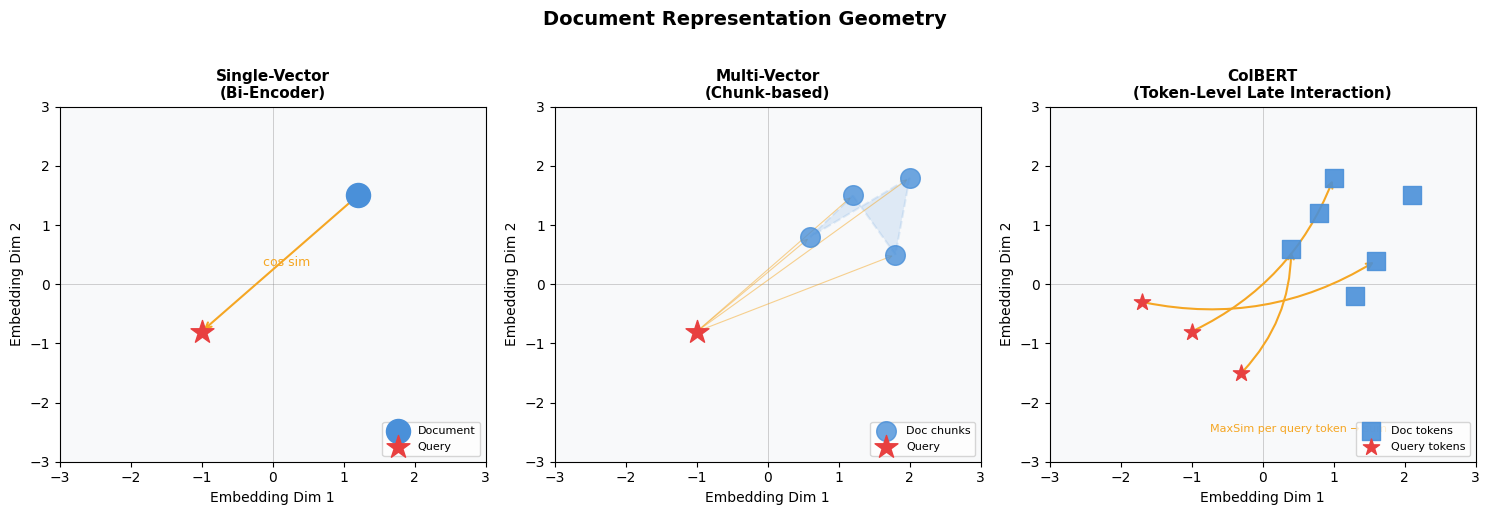

Figure: Geometric intuition for each retrieval architecture


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# VISUAL: Geometric intuition — single point vs. constellation of points
# ─────────────────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Document Representation Geometry', fontsize=14, fontweight='bold', y=1.02)

colors = {'doc': '#4A90D9', 'query': '#E84040', 'interaction': '#F5A623'}

# --- Panel 1: Single Vector ---
ax = axes[0]
ax.set_title('Single-Vector\n(Bi-Encoder)', fontsize=11, fontweight='bold')
ax.set_xlim(-3, 3); ax.set_ylim(-3, 3)
ax.axhline(0, color='gray', lw=0.5, alpha=0.5)
ax.axvline(0, color='gray', lw=0.5, alpha=0.5)
ax.scatter([1.2], [1.5], s=300, c=colors['doc'], zorder=5, label='Document')
ax.scatter([-1.0], [-0.8], s=300, c=colors['query'], zorder=5, marker='*', label='Query')
ax.annotate('', xy=(1.2, 1.5), xytext=(-1.0, -0.8),
            arrowprops=dict(arrowstyle='<->', color=colors['interaction'], lw=1.5))
ax.text(0.2, 0.3, 'cos sim', fontsize=9, color=colors['interaction'], ha='center')
ax.set_xlabel('Embedding Dim 1'); ax.set_ylabel('Embedding Dim 2')
ax.legend(loc='lower right', fontsize=8)
ax.set_facecolor('#F8F9FA')

# --- Panel 2: Multi-Vector ---
ax = axes[1]
ax.set_title('Multi-Vector\n(Chunk-based)', fontsize=11, fontweight='bold')
ax.set_xlim(-3, 3); ax.set_ylim(-3, 3)
ax.axhline(0, color='gray', lw=0.5, alpha=0.5)
ax.axvline(0, color='gray', lw=0.5, alpha=0.5)
doc_points = np.array([[1.2, 1.5], [1.8, 0.5], [0.6, 0.8], [2.0, 1.8]])
ax.scatter(doc_points[:, 0], doc_points[:, 1], s=200, c=colors['doc'],
           zorder=5, alpha=0.8, label='Doc chunks')
# Draw convex hull impression
from matplotlib.patches import Polygon
hull = Polygon(doc_points[[0, 1, 3, 2]], closed=True, fill=True, facecolor='#4A90D9',
               alpha=0.15, edgecolor='#4A90D9', lw=1.5, linestyle='--')
ax.add_patch(hull)
ax.scatter([-1.0], [-0.8], s=300, c=colors['query'], zorder=5, marker='*', label='Query')
for dp in doc_points:
    ax.annotate('', xy=dp, xytext=(-1.0, -0.8),
                arrowprops=dict(arrowstyle='->', color=colors['interaction'], lw=0.8, alpha=0.5))
ax.set_xlabel('Embedding Dim 1'); ax.set_ylabel('Embedding Dim 2')
ax.legend(loc='lower right', fontsize=8)
ax.set_facecolor('#F8F9FA')

# --- Panel 3: ColBERT Token-Level ---
ax = axes[2]
ax.set_title('ColBERT\n(Token-Level Late Interaction)', fontsize=11, fontweight='bold')
ax.set_xlim(-3, 3); ax.set_ylim(-3, 3)
ax.axhline(0, color='gray', lw=0.5, alpha=0.5)
ax.axvline(0, color='gray', lw=0.5, alpha=0.5)
doc_tokens = np.array([[1.0, 1.8], [1.6, 0.4], [0.4, 0.6], [2.1, 1.5], [1.3, -0.2], [0.8, 1.2]])
query_tokens = np.array([[-1.0, -0.8], [-0.3, -1.5], [-1.7, -0.3]])
ax.scatter(doc_tokens[:, 0], doc_tokens[:, 1], s=150, c=colors['doc'],
           zorder=5, alpha=0.9, label='Doc tokens', marker='s')
ax.scatter(query_tokens[:, 0], query_tokens[:, 1], s=150, c=colors['query'],
           zorder=5, marker='*', label='Query tokens')
# MaxSim connections — each query token connects to its nearest doc token
nearest = [0, 2, 1]  # simplified nearest for illustration
for i, qt in enumerate(query_tokens):
    dt = doc_tokens[nearest[i]]
    ax.annotate('', xy=dt, xytext=qt,
                arrowprops=dict(arrowstyle='->', color=colors['interaction'], lw=1.5,
                                connectionstyle='arc3,rad=0.2'))
ax.text(0.5, -2.5, 'MaxSim per query token → sum', fontsize=8,
        color=colors['interaction'], ha='center')
ax.set_xlabel('Embedding Dim 1'); ax.set_ylabel('Embedding Dim 2')
ax.legend(loc='lower right', fontsize=8)
ax.set_facecolor('#F8F9FA')

plt.tight_layout()
plt.savefig('/tmp/geometry_comparison.png', dpi=120, bbox_inches='tight')
plt.show()
print("Figure: Geometric intuition for each retrieval architecture")

> **📌 Key Takeaway from the diagram above:**  
> - Single-vector: a document is *one point*. Retrieval is one dot product.  
> - Multi-vector: a document is a *region* (convex hull of chunk embeddings). Retrieval involves multiple dot products, one per chunk.  
> - ColBERT: every token is its own point. Scoring uses a **MaxSim** operation — each query token finds its *most similar* document token, then we sum these maxima.

---
 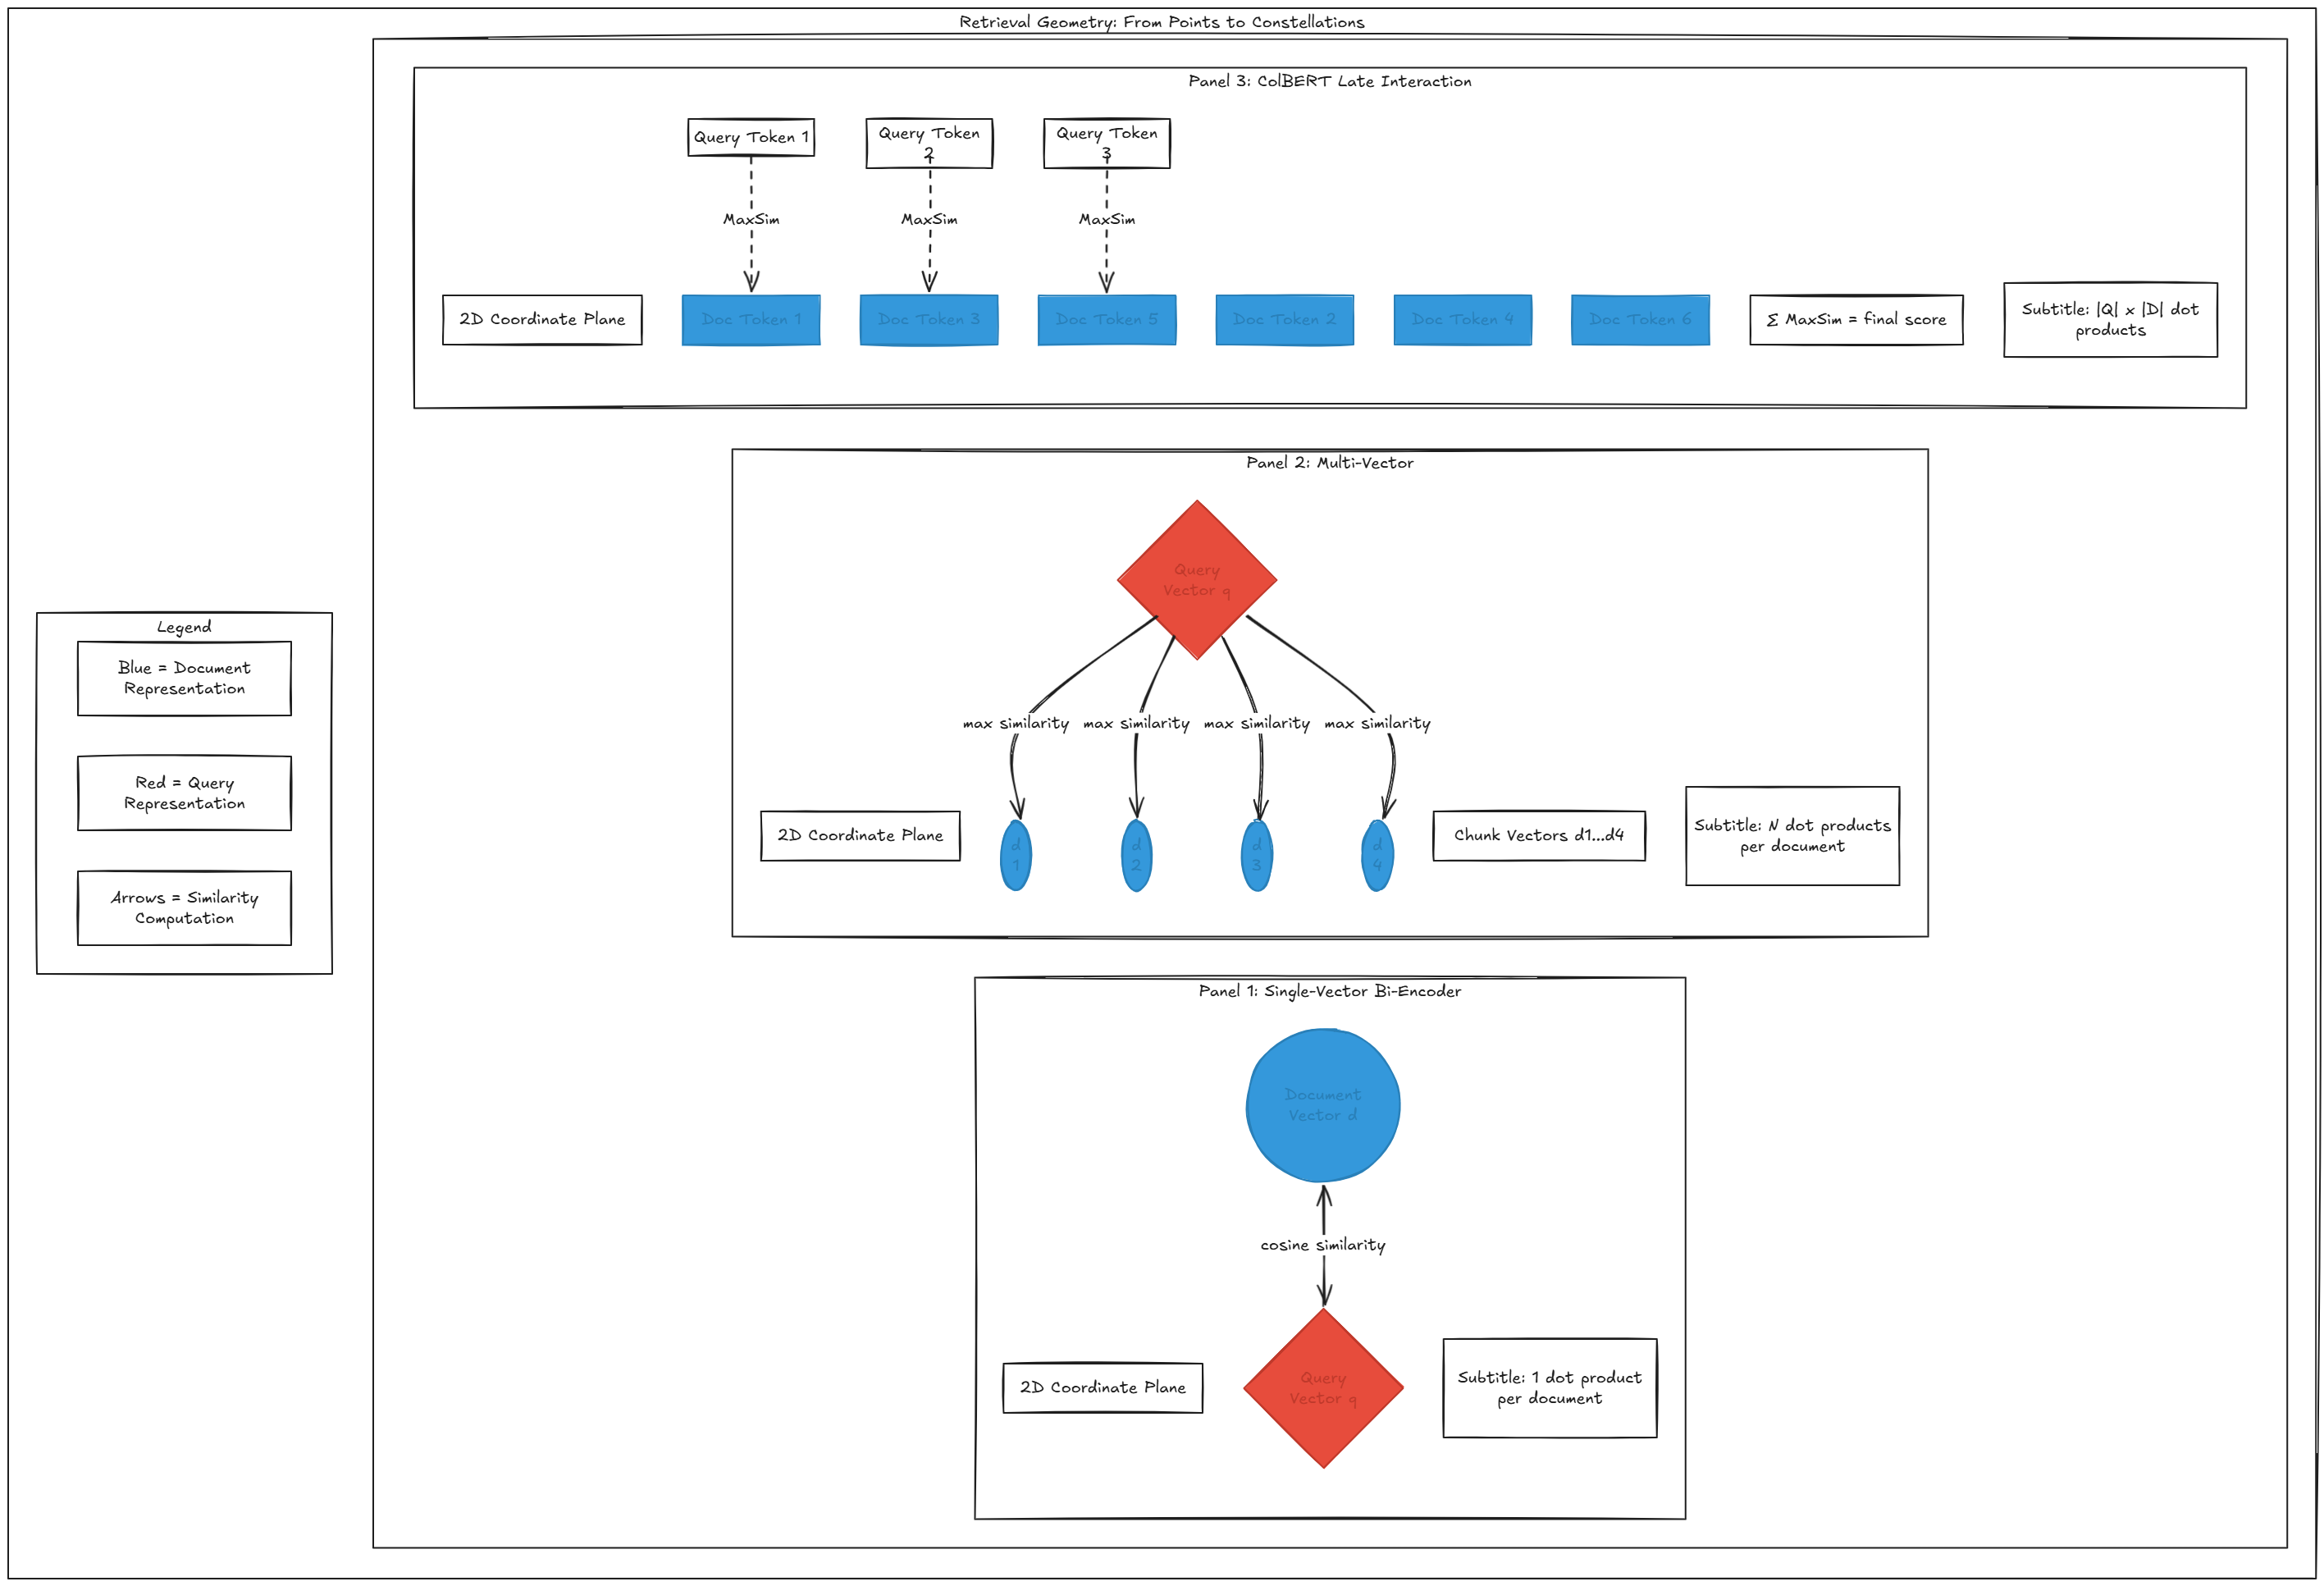

---
<a id='single-vector'></a>
## 3. Normal Sentence Embeddings: Single-Vector Retrieval

### What It Is

A sentence embedding model takes a sequence of text and produces **one fixed-size vector**. The most popular approach today is a **bi-encoder**: two independent BERT-like encoders — one for documents, one for queries — that learn to map semantically similar texts to nearby points in the same vector space.

The canonical architecture looks like:

```
Text → Tokenizer → BERT/Transformer → [CLS] token or Mean Pooling → Single Vector
```

Models like `all-MiniLM-L6-v2`, `text-embedding-ada-002`, or `e5-large` all follow this pattern.

### The Encoding Process

Two common pooling strategies:

1. **[CLS] Token Pooling:** The `[CLS]` token at position 0 is trained to aggregate sentence-level meaning. Its final hidden state becomes the sentence embedding.
2. **Mean Pooling:** Average all token embeddings across sequence length. Generally more robust for variable-length inputs.

```
Tokens:  [CLS] The  bank  by  the  river  [SEP]
Vectors:  h0   h1   h2   h3   h4   h5    h6
          ↓
Mean Pool: (h0 + h1 + ... + h6) / 7  →  embedding ∈ ℝ^768
```

### Retrieval Mechanics

**At index time:** Encode every document → store one vector per document in Qdrant.  
**At query time:** Encode query → find top-k nearest vectors via ANN search (HNSW, etc.).

**Scoring function:**
$$\text{score}(q, d) = \frac{q \cdot d}{|q||d|} \quad \text{(cosine similarity)}$$

### Strengths & Limitations

| ✅ Strengths | ❌ Limitations |
|-------------|----------------|
| Sub-millisecond retrieval (one ANN lookup) | Information bottleneck — all meaning compressed into one vector |
| Storage efficient (1 vector per doc) | Polysemy handling is poor ("bank" ambiguity) |
| Scales to billions of documents | Long document quality degrades with length |
| Easy to deploy | Cross-attention (fine-grained matching) not possible |


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Code Example 1: Single-Vector Indexing with Qdrant
# ─────────────────────────────────────────────────────────────────────────────

# Step 1: Initialize Qdrant in-memory client (no server needed for prototyping)
client = QdrantClient(":memory:")

# Step 2: Load a lightweight sentence embedding model
single_encoder = SentenceTransformer('all-MiniLM-L6-v2')  # 384-dim output
SINGLE_DIM = 384

print(f"Model output dimension: {SINGLE_DIM}")
print(f"Model max sequence length: {single_encoder.max_seq_length}")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model output dimension: 384
Model max sequence length: 256


In [ ]:
# Step 3: Create Qdrant collection for single-vector retrieval
COLLECTION_SINGLE = "single_vector_demo"

client.create_collection(
    collection_name=COLLECTION_SINGLE,
    vectors_config=VectorParams(
        size=SINGLE_DIM,
        distance=Distance.COSINE  # Use cosine similarity
    )
)

print(f"✅ Created collection: '{COLLECTION_SINGLE}'")
print(f"   Vector size: {SINGLE_DIM} | Distance: Cosine")

✅ Created collection: 'single_vector_demo'
   Vector size: 384 | Distance: Cosine


In [ ]:
# Step 4: Sample documents — a mix of topics to test retrieval quality
documents = [
    {"id": 0, "text": "The transformer architecture revolutionized natural language processing."},
    {"id": 1, "text": "Qdrant is a vector database optimized for similarity search at scale."},
    {"id": 2, "text": "ColBERT uses late interaction to enable fine-grained token matching."},
    {"id": 3, "text": "Image retrieval systems encode visual features into dense vectors."},
    {"id": 4, "text": "FAISS is a library for efficient approximate nearest neighbor search."},
    {"id": 5, "text": "Multi-vector representations capture different semantic aspects of a document."},
    {"id": 6, "text": "CLIP aligns image and text embeddings in a shared latent space."},
    {"id": 7, "text": "Bi-encoders are fast at inference but may miss fine-grained query-document interactions."},
]

# Step 5: Encode documents → get single vectors
texts = [doc["text"] for doc in documents]
embeddings = single_encoder.encode(texts, normalize_embeddings=True)

print(f"Encoded {len(embeddings)} documents")
print(f"Embedding shape: {embeddings.shape}  (num_docs × embedding_dim)")

# Step 6: Build PointStructs — Qdrant's unit of data (ADDED doc_idx to payload)
points = [
    PointStruct(
        id=doc["id"],
        vector=embeddings[i].tolist(),                          # The dense vector
        payload={"text": doc["text"], "doc_idx": i}            # Metadata + original array index
    )
    for i, doc in enumerate(documents)
]

# Step 7: Upload to Qdrant
client.upsert(collection_name=COLLECTION_SINGLE, points=points)
print(f"\n✅ Indexed {len(points)} documents into '{COLLECTION_SINGLE}'")
print("📍 Each point now has 'doc_idx' in payload for visualization mapping!")


Encoded 8 documents
Embedding shape: (8, 384)  (num_docs × embedding_dim)

✅ Indexed 8 documents into 'single_vector_demo'
📍 Each point now has 'doc_idx' in payload for visualization mapping!


In [ ]:
query_text = "How does vector similarity search work?"
query_vector = single_encoder.encode(query_text, normalize_embeddings=True).tolist()

results = client.query_points(
    collection_name=COLLECTION_SINGLE,
    query=query_vector,
    limit=3,
    with_payload=True
)

print(f"Query: '{query_text}'\n")
print("Top-3 Results:")
print("-" * 70)
for rank, hit in enumerate(results.points, 1):
    print(f"Rank {rank} | Score: {hit.score:.4f}")
    print(f"  Text: {hit.payload['text']}")
    print()


Query: 'How does vector similarity search work?'

Top-3 Results:
----------------------------------------------------------------------
Rank 1 | Score: 0.6762
  Text: Qdrant is a vector database optimized for similarity search at scale.

Rank 2 | Score: 0.5117
  Text: Image retrieval systems encode visual features into dense vectors.

Rank 3 | Score: 0.4714
  Text: Multi-vector representations capture different semantic aspects of a document.



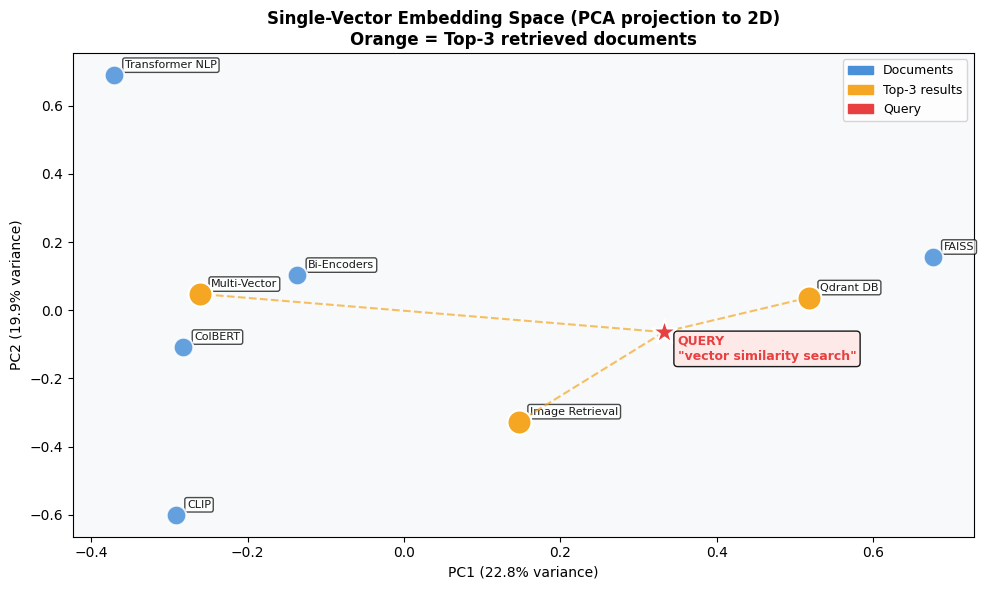

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# VISUALIZATION: Embedding space — 2D PCA projection of our 8 documents
# ─────────────────────────────────────────────────────────────────────────────
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
import numpy as np

pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

# Project query into the same space
query_reduced = pca.transform(np.array(query_vector).reshape(1, -1))

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('#F8F9FA')

# Plot documents
scatter = ax.scatter(reduced[:, 0], reduced[:, 1], s=200, c='#4A90D9',
                     zorder=5, alpha=0.85, edgecolors='white', linewidths=1.5)

# Annotate each document
short_labels = [
    'Transformer NLP', 'Qdrant DB', 'ColBERT', 'Image Retrieval',
    'FAISS', 'Multi-Vector', 'CLIP', 'Bi-Encoders'
]
for i, (x, y) in enumerate(reduced):
    ax.annotate(short_labels[i], (x, y), textcoords='offset points',
                xytext=(8, 5), fontsize=8, alpha=0.9,
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7))

# Plot query
ax.scatter(query_reduced[:, 0], query_reduced[:, 1], s=350, c='#E84040',
           zorder=10, marker='*', edgecolors='white', linewidths=1.5, label='Query')
ax.annotate('QUERY\n"vector similarity search"',
            (query_reduced[0, 0], query_reduced[0, 1]),
            textcoords='offset points', xytext=(10, -20), fontsize=9,
            color='#E84040', fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='#FFE8E8', alpha=0.9))

# Draw lines to top-3 results (FIXED: use results.points and payload doc_idx)
top3_hits = results.points[:3]  # Get top 3 ScoredPoint objects
for rank, hit in enumerate(top3_hits, 1):
    doc_idx = hit.payload['doc_idx']

    # Draw connecting line
    ax.plot([query_reduced[0, 0], reduced[doc_idx, 0]],
            [query_reduced[0, 1], reduced[doc_idx, 1]],
            '--', color='#F5A623', lw=1.5, alpha=0.7, zorder=3)

    # Highlight top-3 points
    ax.scatter(reduced[doc_idx, 0], reduced[doc_idx, 1], s=300, c='#F5A623',
               zorder=6, edgecolors='white', linewidths=1.5)

ax.set_title('Single-Vector Embedding Space (PCA projection to 2D)\nOrange = Top-3 retrieved documents',
             fontsize=12, fontweight='bold')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')

doc_patch = mpatches.Patch(color='#4A90D9', label='Documents')
top_patch = mpatches.Patch(color='#F5A623', label='Top-3 results')
q_patch = mpatches.Patch(color='#E84040', label='Query')
ax.legend(handles=[doc_patch, top_patch, q_patch], fontsize=9)
plt.tight_layout()
plt.savefig('/tmp/embedding_space.png', dpi=120, bbox_inches='tight')
plt.show()


The PCA projection above shows our 8 documents in 2D embedding space. Notice how semantically related documents (FAISS, Qdrant, Multi-Vector, Bi-Encoders) cluster together. The query lands closest to these, which is exactly what we retrieved.

> **Engineering Note:** The PCA projection is lossy (we're squishing 384 dims to 2), but it gives a useful intuition. In real 384-D space, the angular distances are what matter for cosine similarity retrieval.

---
<a id='multi-vector'></a>
## 4. Multi-Vector Retrieval: Representing Documents as Sets

### The Core Idea

Instead of compressing a document into **one** vector, multi-vector retrieval represents a document as **multiple** vectors — one per semantic chunk, paragraph, or aspect.

The motivation is straightforward: a long document covers many different sub-topics. A single vector averages these topics together, diluting the signal. If you chunk the document and embed each chunk independently, you preserve the local semantic density of each part.

### Chunking Strategy

How you chunk determines the quality of your multi-vector representation:

```
Document
   │
   ├── Chunk 1: "Qdrant is a vector database..."          → vector v1 ∈ ℝ^384
   ├── Chunk 2: "It supports HNSW and scalar quantization" → vector v2 ∈ ℝ^384
   ├── Chunk 3: "Qdrant also supports multi-vector docs"   → vector v3 ∈ ℝ^384
   └── Chunk 4: "The Rust implementation makes it fast"    → vector v4 ∈ ℝ^384
```

### Retrieval Mechanics

**At query time**, you encode the query into one vector `q`, then score each document `D` as:

$$\text{score}(q, D) = \max_{v \in D} \cos(q, v)$$

You take the **maximum** similarity over all chunk vectors. This is called **MaxSim** pooling at the document level. Intuitively: "Does any chunk of this document match the query?"

Alternative: **sum** or **mean** pooling across chunk scores. The choice depends on whether you want to reward breadth (sum) or depth (max).

### The Two Storage Patterns in Qdrant

**Pattern A — One point per chunk** (simple, flexible):
```
Point 1: { id: "doc1_chunk0", vector: v1, payload: {doc_id: "doc1", chunk_idx: 0} }
Point 2: { id: "doc1_chunk1", vector: v2, payload: {doc_id: "doc1", chunk_idx: 1} }
```
After ANN search, group results by `doc_id` and aggregate scores.

**Pattern B — Multi-vector point** (Qdrant native, since v1.7+):
```
Point 1: { id: "doc1", vectors: [v1, v2, v3, v4], payload: {title: "..."}  }
```
Qdrant stores all vectors for a single point and natively computes MaxSim scoring.

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Code Example 2: Multi-Vector Indexing with Qdrant (Pattern B — native)
# ─────────────────────────────────────────────────────────────────────────────

COLLECTION_MULTI = "multi_vector_demo"

# Qdrant's native multi-vector collection
# MultiVectorComparator.MAX_SIM → score = max cosine sim over all vectors
client.create_collection(
    collection_name=COLLECTION_MULTI,
    vectors_config=VectorParams(
        size=SINGLE_DIM,
        distance=Distance.COSINE,
        multivector_config=MultiVectorConfig(
            comparator=MultiVectorComparator.MAX_SIM  # MaxSim scoring
        )
    )
)

print(f"✅ Created multi-vector collection: '{COLLECTION_MULTI}'")
print(f"   Comparator: MAX_SIM — scores = max cosine sim across all vectors")

✅ Created multi-vector collection: 'multi_vector_demo'
   Comparator: MAX_SIM — scores = max cosine sim across all vectors


In [ ]:
# Sample multi-paragraph documents
multi_docs = [
    {
        "id": 0,
        "title": "Qdrant Vector Database",
        "chunks": [
            "Qdrant is a high-performance vector database written in Rust.",
            "It supports HNSW indexing for fast approximate nearest neighbor search.",
            "Qdrant offers native multi-vector support with MaxSim scoring.",
            "Scalar and product quantization reduce memory footprint significantly."
        ]
    },
    {
        "id": 1,
        "title": "ColBERT Architecture",
        "chunks": [
            "ColBERT encodes both queries and documents into sets of token-level vectors.",
            "Late interaction means query-document scoring happens at retrieval time.",
            "The MaxSim operator computes per-query-token maximum similarity.",
            "ColBERT achieves cross-encoder quality at bi-encoder speed."
        ]
    },
    {
        "id": 2,
        "title": "Image Embedding Systems",
        "chunks": [
            "Visual transformers like ViT encode images into dense representation vectors.",
            "CLIP jointly trains image and text encoders with contrastive loss.",
            "Patch-level image embeddings preserve spatial information.",
            "Image retrieval systems can combine visual and textual features."
        ]
    }
]

# Encode all chunks and build multi-vector points
multi_points = []
for doc in multi_docs:
    chunk_embeddings = single_encoder.encode(
        doc["chunks"], normalize_embeddings=True
    )
    # Each point stores a LIST of vectors — one per chunk
    multi_points.append(
        PointStruct(
            id=doc["id"],
            vector=chunk_embeddings.tolist(),   # shape: [num_chunks, dim]
            payload={"title": doc["title"], "chunks": doc["chunks"]}
        )
    )
    print(f"  Doc {doc['id']} '{doc['title']}': {len(doc['chunks'])} chunks → "
          f"shape {chunk_embeddings.shape}")

client.upsert(collection_name=COLLECTION_MULTI, points=multi_points)
print(f"\n✅ Indexed {len(multi_points)} multi-vector documents into '{COLLECTION_MULTI}'")

  Doc 0 'Qdrant Vector Database': 4 chunks → shape (4, 384)
  Doc 1 'ColBERT Architecture': 4 chunks → shape (4, 384)
  Doc 2 'Image Embedding Systems': 4 chunks → shape (4, 384)

✅ Indexed 3 multi-vector documents into 'multi_vector_demo'


In [ ]:
# Query the multi-vector collection
# Note: query is still a single vector (1D list), but scoring uses MaxSim
mv_query = "How does Qdrant handle approximate nearest neighbor search?"

# ✅ Wrap in a list → shape [1, dim] to match multi-vector format
mv_query_vec = [single_encoder.encode(mv_query, normalize_embeddings=True).tolist()]

mv_results = client.query_points(
    collection_name=COLLECTION_MULTI,
    query=mv_query_vec,
    limit=3,
    with_payload=True
)

print(f"Query: '{mv_query}'\n")
print("Multi-Vector MaxSim Results:")
print("-" * 70)
for rank, hit in enumerate(mv_results.points, 1):
    print(f"Rank {rank} | MaxSim Score: {hit.score:.4f} | Doc: '{hit.payload['title']}'")

print("\n💡 The score reflects the MAXIMUM similarity between the query and")
print("   any single chunk in the document — not an average.")


Query: 'How does Qdrant handle approximate nearest neighbor search?'

Multi-Vector MaxSim Results:
----------------------------------------------------------------------
Rank 1 | MaxSim Score: 0.5504 | Doc: 'Qdrant Vector Database'
Rank 2 | MaxSim Score: 0.3720 | Doc: 'ColBERT Architecture'
Rank 3 | MaxSim Score: 0.2236 | Doc: 'Image Embedding Systems'

💡 The score reflects the MAXIMUM similarity between the query and
   any single chunk in the document — not an average.


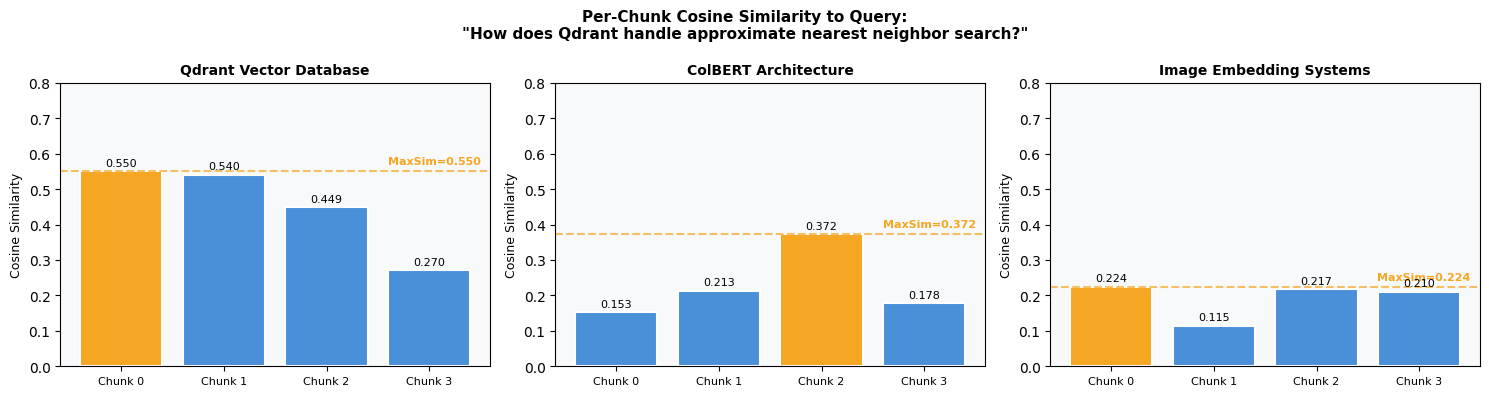

Orange bars = the winning chunk (MaxSim value)


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# VISUALIZATION: MaxSim scoring — show per-chunk similarity
# ─────────────────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=False)
fig.suptitle(f'Per-Chunk Cosine Similarity to Query:\n"{mv_query}"',
             fontsize=11, fontweight='bold')

for ax_idx, doc in enumerate(multi_docs):
    chunk_embs = single_encoder.encode(doc["chunks"], normalize_embeddings=True)
    qvec = np.array(mv_query_vec[0])
    sims = chunk_embs @ qvec  # cosine sim (already normalized)

    bars = axes[ax_idx].bar(
        range(len(sims)), sims,
        color=['#F5A623' if s == max(sims) else '#4A90D9' for s in sims],
        edgecolor='white', linewidth=1.5
    )
    axes[ax_idx].set_title(doc['title'], fontsize=10, fontweight='bold')
    axes[ax_idx].set_xticks(range(len(sims)))
    axes[ax_idx].set_xticklabels([f'Chunk {i}' for i in range(len(sims))], fontsize=8)
    axes[ax_idx].set_ylabel('Cosine Similarity', fontsize=9)
    axes[ax_idx].set_ylim(0, 0.8)
    axes[ax_idx].axhline(max(sims), color='#F5A623', linestyle='--', lw=1.5, alpha=0.7)
    axes[ax_idx].text(len(sims)-0.5, max(sims)+0.02, f'MaxSim={max(sims):.3f}',
                      ha='right', fontsize=8, color='#F5A623', fontweight='bold')
    axes[ax_idx].set_facecolor('#F8F9FA')

    # Add value labels on bars
    for bar, val in zip(bars, sims):
        axes[ax_idx].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                          f'{val:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('/tmp/maxsim_chunks.png', dpi=120, bbox_inches='tight')
plt.show()
print("Orange bars = the winning chunk (MaxSim value)")

The chart above reveals how MaxSim works: for the Qdrant document, one specific chunk mentioning HNSW scores highest and becomes the document's score. This is fundamentally different from a single-vector approach where all this information would be averaged away.

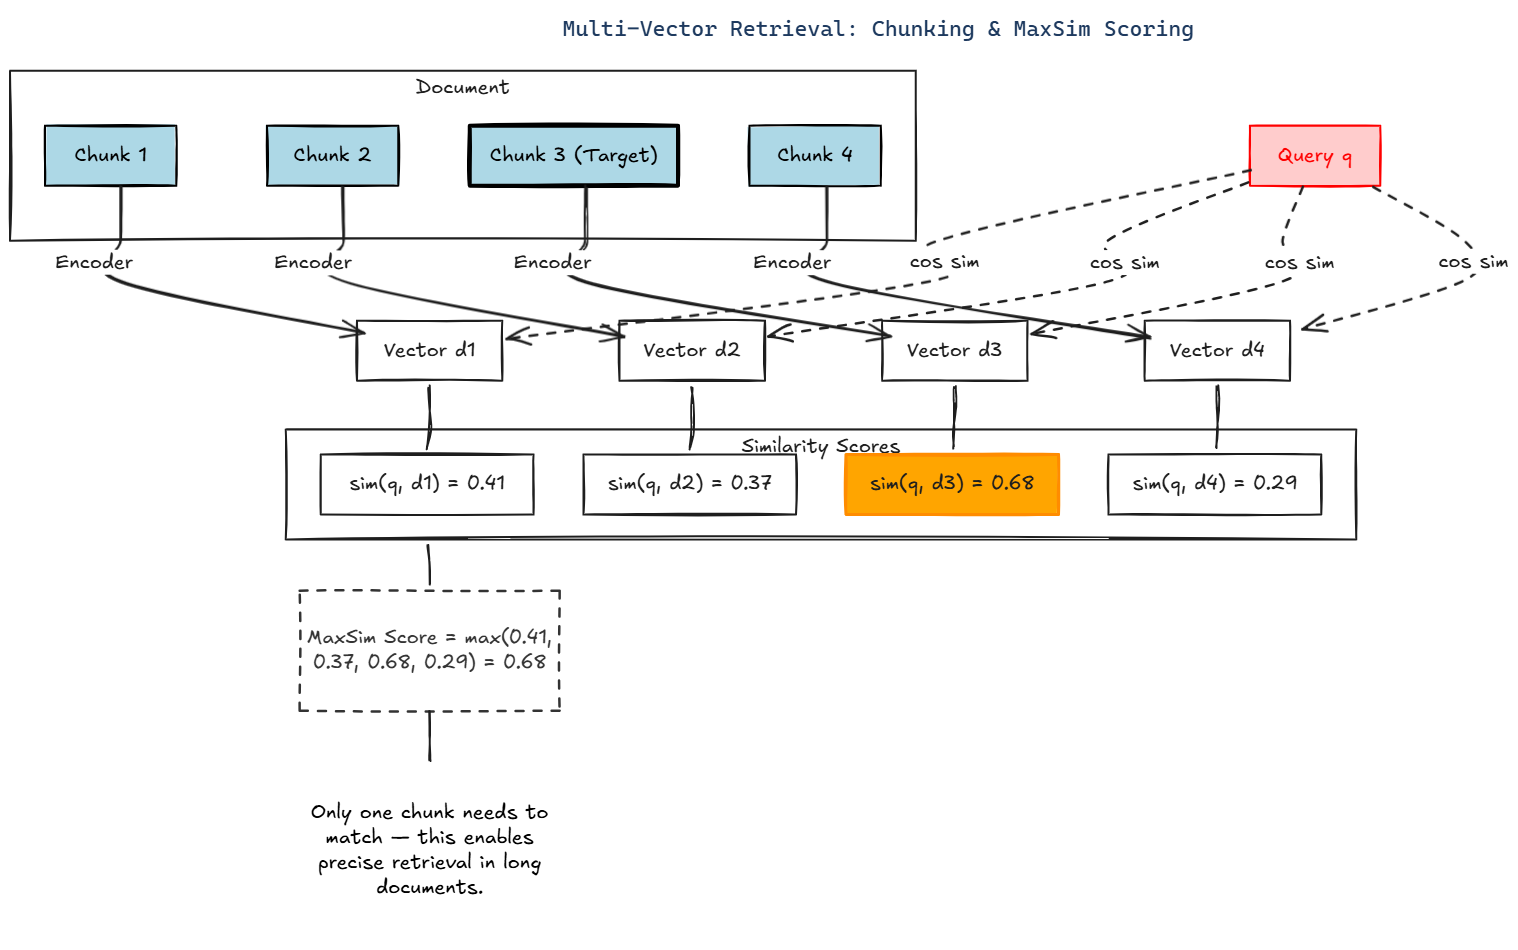
```

<a id='colbert'></a>
## 5. ColBERT: Late Interaction and Token-Level Matching

### The Architecture Philosophy

ColBERT (Contextualized Late Interaction over BERT) was introduced by Khattab & Zaharia in 2020 to answer a specific question: **Can we get cross-encoder quality while keeping bi-encoder speed?**

Understanding this requires knowing the trade-off triangle:

```
                    QUALITY
                      ▲
                      │
             Cross-Encoder
             (joint encoding,
              expensive but accurate)
                      │
              ColBERT  ← The sweet spot
              (late interaction)
                      │
              Bi-Encoder
              (independent encoding,
               fast but coarser)
                      │
   SPEED ◄────────────┴────────────► PRECISION
```

### How ColBERT Works — Step by Step

**Step 1 — Independent Encoding (like a bi-encoder):**
```
Query:    "what causes muddy rivers" → BERT → [q1, q2, q3, q4, q5]   (5 token vectors)
Document: "the bank by the river..." → BERT → [d1, d2, d3, d4, d5, d6, d7]  (7 token vectors)
```

**Step 2 — Late Interaction (MaxSim per query token):**
$$\text{score}(Q, D) = \sum_{i=1}^{|Q|} \max_{j=1}^{|D|} q_i \cdot d_j$$

For each query token, find the highest-scoring document token, then sum all those maxima.

**Why this is powerful:**
- Token `q_i = "muddy"` will find its best match in `{d_j}`, maybe `d_j = "muddy"` or `d_k = "silt"`
- Token `q_i = "rivers"` will match with `d_k = "river"` or `d_l = "stream"`
- The final score aggregates evidence from **all** query aspects

This is fundamentally different from single-vector retrieval where all this nuance is collapsed before scoring.

### Offline vs. Online Computation

| Phase | Single-Vector | ColBERT |
|-------|-------------|--------|
| Indexing | Encode doc → 1 vector | Encode doc → M vectors (M = doc length) |
| Query encoding | 1 vector | K vectors (K = query length) |
| Scoring | 1 dot product | K × M dot products + K max operations |
| Storage | 1 × D floats per doc | M × D floats per doc (typically 100–512 tokens) |

### The Key Architectural Difference from Multi-Vector Chunking

| Aspect | Multi-Vector (Chunking) | ColBERT |
|--------|------------------------|--------|
| Granularity | Paragraph/sentence chunks | Individual tokens |
| Vectors per doc | 4–20 (few chunks) | 50–512 (all tokens) |
| Interaction | Query vector vs. chunk vectors | Each query token vs. all doc tokens |
| Context awareness | Chunk is independently encoded | Token is contextually encoded (BERT) |
| Storage cost | Moderate | High |
| Retrieval quality | Good | Excellent (near cross-encoder) |

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Code Example 3: Simulating ColBERT-style Late Interaction
# In production, use ragatouille or pylate for ColBERT.
# Here we simulate the mechanics with a standard transformer to build intuition.
# ─────────────────────────────────────────────────────────────────────────────

from transformers import AutoTokenizer, AutoModel

# We'll use a small transformer and extract per-token embeddings
MODEL_NAME = 'sentence-transformers/all-MiniLM-L6-v2'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
token_model = AutoModel.from_pretrained(MODEL_NAME)
token_model.eval()

def get_token_embeddings(text: str, normalize: bool = True) -> np.ndarray:
    """
    Extract per-token embeddings (ColBERT-style representation).
    Returns: array of shape [seq_len, hidden_dim]
    """
    inputs = tokenizer(text, return_tensors='pt', padding=True,
                       truncation=True, max_length=64)
    with torch.no_grad():
        outputs = token_model(**inputs)

    # Use last hidden states: shape [batch, seq_len, hidden_dim] [1, 5, 768]
    token_vecs = outputs.last_hidden_state[0].numpy()  # Remove batch dim

    # Remove [CLS] and [SEP] tokens (indices 0 and -1)
    token_vecs = token_vecs[1:-1]

    if normalize:
        norms = np.linalg.norm(token_vecs, axis=1, keepdims=True)
        token_vecs = token_vecs / (norms + 1e-8)

    return token_vecs

def late_interaction_score(query_text: str, doc_text: str) -> float:
    """
    Compute ColBERT-style late interaction score.
    Score = sum over query tokens of max similarity to any doc token.
    """
    q_vecs = get_token_embeddings(query_text)  # [|Q|, D]
    d_vecs = get_token_embeddings(doc_text)    # [|D|, D]

    # Compute full similarity matrix: [|Q|, |D|]
    sim_matrix = q_vecs @ d_vecs.T

    # MaxSim: for each query token, take max over all doc tokens
    max_sims = sim_matrix.max(axis=1)  # [|Q|]

    # Sum over query tokens
    return float(max_sims.sum())

print("ColBERT Late Interaction Score Demo")
print("=" * 50)

query = "How does vector similarity search work?"
test_docs = [
    ("Qdrant is a vector database optimized for similarity search.",        "Relevant"),
    ("FAISS enables efficient approximate nearest neighbor search at scale.","Relevant"),
    ("Paris is the capital of France and home to the Eiffel Tower.",         "Irrelevant"),
    ("ColBERT uses token-level vectors to improve retrieval precision.",     "Semi-relevant"),
]

print(f"\nQuery: '{query}'\n")
for doc_text, label in test_docs:
    score = late_interaction_score(query, doc_text)
    print(f"[{label:12s}] Score: {score:6.3f} | '{doc_text[:55]}...'")

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


ColBERT Late Interaction Score Demo

Query: 'How does vector similarity search work?'

[Relevant    ] Score:  4.878 | 'Qdrant is a vector database optimized for similarity se...'
[Relevant    ] Score:  3.179 | 'FAISS enables efficient approximate nearest neighbor se...'
[Irrelevant  ] Score:  0.473 | 'Paris is the capital of France and home to the Eiffel T...'
[Semi-relevant] Score:  3.319 | 'ColBERT uses token-level vectors to improve retrieval p...'


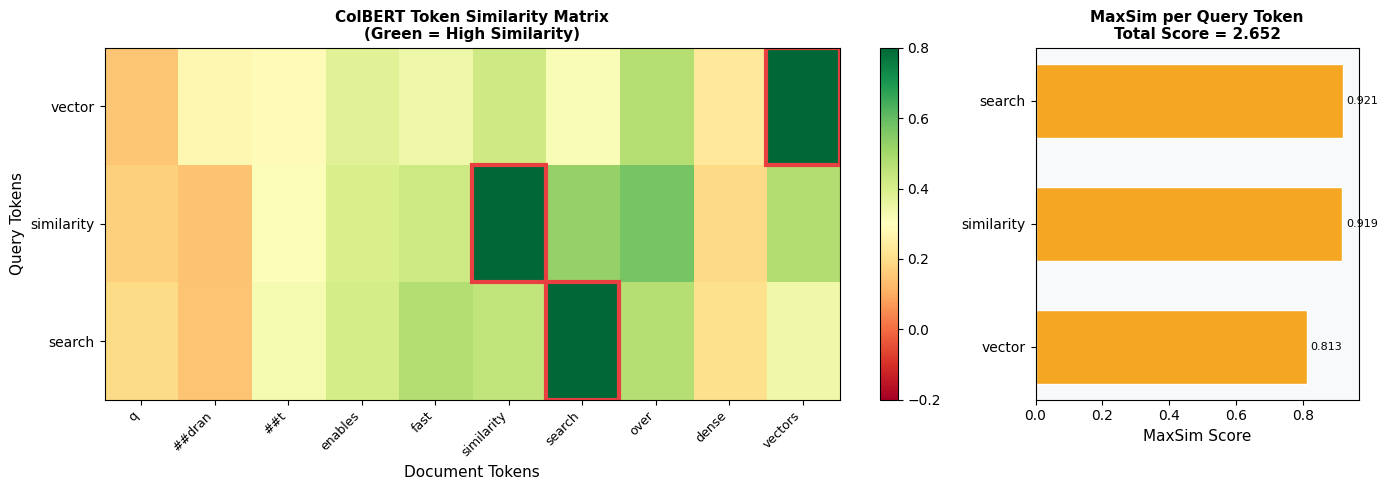

Red boxes on heatmap = MaxSim winner for each query token
Final ColBERT Score = sum of MaxSim values = 2.652


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# VISUALIZATION: Token-level similarity matrix (the heart of ColBERT)
# ─────────────────────────────────────────────────────────────────────────────

query_text = "vector similarity search"
doc_text   = "Qdrant enables fast similarity search over dense vectors"

q_vecs = get_token_embeddings(query_text)
d_vecs = get_token_embeddings(doc_text)
sim_matrix = q_vecs @ d_vecs.T

# Get readable token labels
q_tokens = tokenizer.tokenize(query_text)
d_tokens = tokenizer.tokenize(doc_text)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5),
                                gridspec_kw={'width_ratios': [2.5, 1]})

# Heatmap of full similarity matrix
im = ax1.imshow(sim_matrix, cmap='RdYlGn', aspect='auto',
                vmin=-0.2, vmax=0.8)
ax1.set_xticks(range(len(d_tokens)))
ax1.set_xticklabels(d_tokens, rotation=45, ha='right', fontsize=9)
ax1.set_yticks(range(len(q_tokens)))
ax1.set_yticklabels(q_tokens, fontsize=10)
ax1.set_xlabel('Document Tokens', fontsize=11)
ax1.set_ylabel('Query Tokens', fontsize=11)
ax1.set_title('ColBERT Token Similarity Matrix\n(Green = High Similarity)', fontsize=11, fontweight='bold')
plt.colorbar(im, ax=ax1, fraction=0.04)

# Highlight MaxSim for each query token
max_idx = sim_matrix.argmax(axis=1)
for i, j in enumerate(max_idx):
    ax1.add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1,
                                  fill=False, edgecolor='#E84040', lw=3))

# Bar chart of MaxSim per query token
max_sims = sim_matrix.max(axis=1)
bars = ax2.barh(range(len(q_tokens)), max_sims,
                color=['#4A90D9' if v < 0.5 else '#F5A623' for v in max_sims],
                edgecolor='white', height=0.6)
ax2.set_yticks(range(len(q_tokens)))
ax2.set_yticklabels(q_tokens, fontsize=10)
ax2.set_xlabel('MaxSim Score', fontsize=11)
ax2.set_title(f'MaxSim per Query Token\nTotal Score = {max_sims.sum():.3f}',
              fontsize=11, fontweight='bold')
ax2.axvline(0, color='gray', lw=0.5)
ax2.set_facecolor('#F8F9FA')
for bar, val in zip(bars, max_sims):
    ax2.text(val + 0.01, bar.get_y() + bar.get_height()/2,
             f'{val:.3f}', va='center', fontsize=8)

plt.tight_layout()
plt.savefig('/tmp/colbert_interaction.png', dpi=120, bbox_inches='tight')
plt.show()
print("Red boxes on heatmap = MaxSim winner for each query token")
print(f"Final ColBERT Score = sum of MaxSim values = {max_sims.sum():.3f}")

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Code Example 4: ColBERT-style Qdrant Collection
# Each document stored as a multi-vector (one vector per token)
# ─────────────────────────────────────────────────────────────────────────────

COLLECTION_COLBERT = "colbert_demo"
COLBERT_DIM = token_model.config.hidden_size  # 384 for MiniLM

client.create_collection(
    collection_name=COLLECTION_COLBERT,
    vectors_config=VectorParams(
        size=COLBERT_DIM,
        distance=Distance.COSINE,
        multivector_config=MultiVectorConfig(
            comparator=MultiVectorComparator.MAX_SIM
        )
    )
)

# Index documents as token-level vector sets
colbert_docs = [
    {"id": 0, "text": "Qdrant is a vector database optimized for similarity search."},
    {"id": 1, "text": "ColBERT uses late interaction for high-quality document retrieval."},
    {"id": 2, "text": "Image embeddings can be stored and searched in Qdrant collections."},
    {"id": 3, "text": "HNSW graph indexing enables approximate nearest neighbor search."},
]

colbert_points = []
for doc in colbert_docs:
    token_vecs = get_token_embeddings(doc["text"])  # [n_tokens, 384]
    colbert_points.append(
        PointStruct(
            id=doc["id"],
            vector=token_vecs.tolist(),  # list of token vectors
            payload={"text": doc["text"], "n_tokens": len(token_vecs)}
        )
    )
    print(f"  Doc {doc['id']}: {len(token_vecs)} tokens → {len(token_vecs)} vectors stored")

client.upsert(collection_name=COLLECTION_COLBERT, points=colbert_points)
print(f"\n✅ Indexed {len(colbert_points)} documents into '{COLLECTION_COLBERT}'")
print("   Each document is a SET of token vectors — Qdrant handles MaxSim scoring natively")

  Doc 0: 14 tokens → 14 vectors stored
  Doc 1: 11 tokens → 11 vectors stored
  Doc 2: 16 tokens → 16 vectors stored
  Doc 3: 12 tokens → 12 vectors stored

✅ Indexed 4 documents into 'colbert_demo'
   Each document is a SET of token vectors — Qdrant handles MaxSim scoring natively


In [ ]:
# Query the ColBERT collection — query is also a set of token vectors
colbert_query_text = "similarity search vector database"
colbert_query_vecs = get_token_embeddings(colbert_query_text).tolist()

print(f"Query: '{colbert_query_text}'")
print(f"Query token count: {len(colbert_query_vecs)} vectors")

colbert_results = client.query_points(
    collection_name=COLLECTION_COLBERT,
    query=colbert_query_vecs,
    limit=3,
    with_payload=True
).points

print("\nColBERT Late-Interaction Results:")
print("-" * 70)
for rank, hit in enumerate(colbert_results, 1):
    print(f"Rank {rank} | MaxSim Score: {hit.score:.4f} | Tokens: {hit.payload['n_tokens']}")
    print(f"  Text: {hit.payload['text']}")
    print()

Query: 'similarity search vector database'
Query token count: 4 vectors

ColBERT Late-Interaction Results:
----------------------------------------------------------------------
Rank 1 | MaxSim Score: 3.6570 | Tokens: 14
  Text: Qdrant is a vector database optimized for similarity search.

Rank 2 | MaxSim Score: 1.9922 | Tokens: 12
  Text: HNSW graph indexing enables approximate nearest neighbor search.

Rank 3 | MaxSim Score: 1.6694 | Tokens: 16
  Text: Image embeddings can be stored and searched in Qdrant collections.



---
<a id='poly'></a>
## 6. Poly-Encoders: Structured Multi-Vector Compression

### The Design Problem Poly-Encoders Solve

ColBERT is powerful, but it's expensive. Storing M vectors per document and computing K×M dot products per query-doc pair doesn't scale when you have millions of documents and millisecond latency requirements.

Poly-encoders (Humeau et al., 2020) take a different approach: **compress the document into a small, fixed number of learned "global codes"** — typically 16, 32, or 64 vectors. These codes aren't chunks or tokens; they're **learned linear combinations** of all token embeddings.

### Architecture

**Document Encoding (offline):**
```
Document tokens → Transformer → [h1, h2, ..., hM]  (token hidden states)
                                    ↓
                         P learned global codes (attention-weighted)
                         y1, y2, ..., yP  where P << M
```

**Query Encoding + Interaction (online):**
```
Query → Transformer → [CLS] token → q_embedding
                                       ↓
                      Attend over {y1,...,yP} using q as attention query
                                       ↓
                              Contextualized doc vector y_ctx
                                       ↓
                              score = q_embedding · y_ctx
```

The key insight: document codes are precomputed and stored (offline). The attention over P codes is P dot products — much cheaper than ColBERT's K×M.

### Poly-Encoder vs. ColBERT — Where They Differ

| Property | ColBERT | Poly-Encoder |
|----------|---------|-------------|
| Doc representation | All M token vectors | P learned code vectors |
| Storage per doc | M × D (large) | P × D (compact, P=16-64) |
| Scoring | Sum of MaxSim | Attention over P codes |
| Interaction type | Token-to-token | Code-to-query-attention |
| Quality vs. speed | Leans quality | Configurable (tune P) |
| ANN indexing | Hard (per-token lookup) | Easier (fixed-size P vectors) |

### The P Parameter Tradeoff

| P Value | Interpretation |
|---------|----------------|
| P = 1 | Reduces to standard bi-encoder |
| P = 16 | Good balance, common default |
| P = 64 | Better quality, higher cost |
| P = M (all tokens) | Approaches cross-encoder quality |

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Code Example 5: Simulating Poly-Encoder Global Codes
# ─────────────────────────────────────────────────────────────────────────────

class SimulatedPolyEncoder:
    """
    Simplified Poly-Encoder simulation.

    Real poly-encoders learn global code attention weights during training.
    Here we simulate with random projection to illustrate the mechanism.
    """

    def __init__(self, hidden_dim: int, n_codes: int = 16):
        self.hidden_dim = hidden_dim
        self.n_codes = n_codes
        # Global code embeddings — learned during training
        # Shape: [n_codes, hidden_dim]
        self.global_codes = np.random.randn(n_codes, hidden_dim)
        self.global_codes /= np.linalg.norm(self.global_codes, axis=1, keepdims=True)

    def encode_document(self, token_embeddings: np.ndarray) -> np.ndarray:
        """
        Produce P global codes from M token embeddings.
        Each code y_i = attention_weighted sum of token embeddings,
        with weights defined by global_code[i].

        Returns: [n_codes, hidden_dim]
        """
        # Attention scores: [n_codes, M]
        attn_scores = self.global_codes @ token_embeddings.T

        # Softmax over tokens for each code
        attn_weights = np.exp(attn_scores) / np.exp(attn_scores).sum(axis=1, keepdims=True)

        # Weighted sum: [n_codes, hidden_dim]
        codes = attn_weights @ token_embeddings
        codes /= np.linalg.norm(codes, axis=1, keepdims=True) + 1e-8
        return codes  # These are the stored "poly codes"

    def score(self, query_vec: np.ndarray, doc_codes: np.ndarray) -> float:
        """
        Score a query against document poly codes.
        1) Attend over doc codes using query
        2) Dot product with attended vector
        """
        # Attention over codes using query: [n_codes]
        attn = query_vec @ doc_codes.T
        attn_weights = np.exp(attn) / np.exp(attn).sum() # Softmax

        # Attended document vector: [hidden_dim], Weighted sum
        attended_doc = attn_weights @ doc_codes
        attended_doc /= np.linalg.norm(attended_doc) + 1e-8 # Normalize

        return float(query_vec @ attended_doc)

# Demonstrate
DIM = COLBERT_DIM  # 384
poly = SimulatedPolyEncoder(hidden_dim=DIM, n_codes=16)

test_doc = "Qdrant is a vector database for similarity search at scale."
test_query = "vector database similarity search"

doc_token_vecs  = get_token_embeddings(test_doc)    # [M, 384]
doc_poly_codes  = poly.encode_document(doc_token_vecs)  # [16, 384]
query_vec       = single_encoder.encode(test_query, normalize_embeddings=True)

poly_score      = poly.score(query_vec, doc_poly_codes)

print("Poly-Encoder Demo")
print("-" * 50)
print(f"Document token count  : {len(doc_token_vecs)} tokens × {DIM}d = "
      f"{len(doc_token_vecs) * DIM * 4 / 1024:.1f} KB (ColBERT storage)")
print(f"Poly codes            : {len(doc_poly_codes)} codes × {DIM}d = "
      f"{len(doc_poly_codes) * DIM * 4 / 1024:.1f} KB (Poly-Encoder storage)")
print(f"Storage compression   : {len(doc_token_vecs)/len(doc_poly_codes):.1f}x reduction")
print(f"Poly-Encoder Score    : {poly_score:.4f}")

Poly-Encoder Demo
--------------------------------------------------
Document token count  : 13 tokens × 384d = 19.5 KB (ColBERT storage)
Poly codes            : 16 codes × 384d = 24.0 KB (Poly-Encoder storage)
Storage compression   : 0.8x reduction
Poly-Encoder Score    : 0.7689


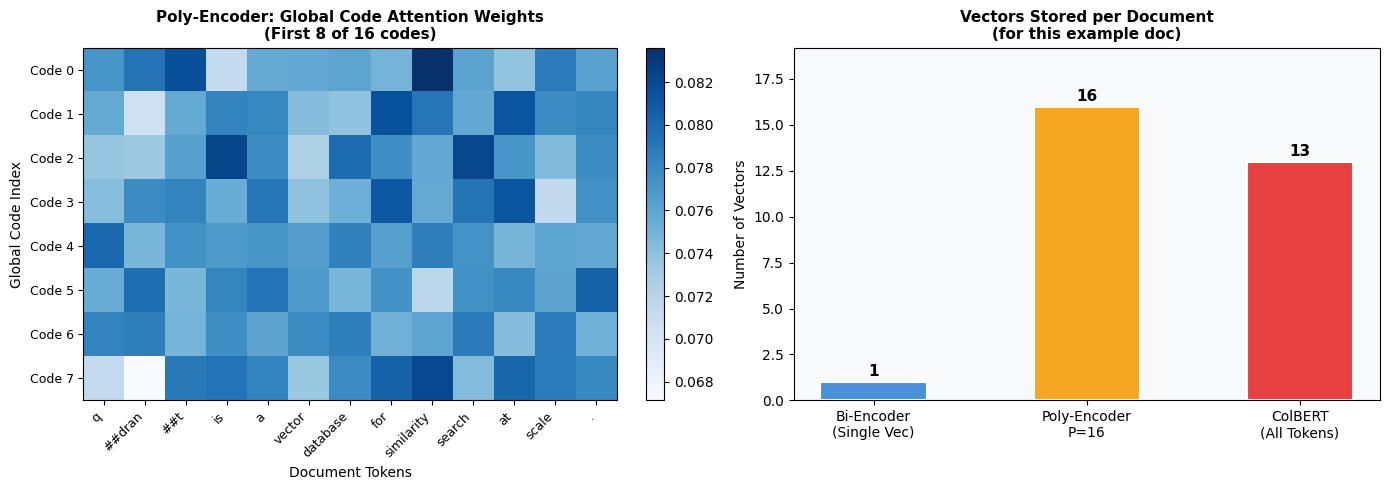

The sweet spot of Poly-Encoders is the configurable P parameter:
P=1 → bi-encoder | P=M → near cross-encoder quality


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# VISUALIZATION: Poly-Encoder compression — tokens → codes
# ─────────────────────────────────────────────────────────────────────────────

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: attention weights for each global code
tokens = tokenizer.tokenize(test_doc)
attn_scores = poly.global_codes @ doc_token_vecs.T
attn_weights = np.exp(attn_scores) / np.exp(attn_scores).sum(axis=1, keepdims=True)

im = axes[0].imshow(attn_weights[:8, :], cmap='Blues', aspect='auto')
axes[0].set_xticks(range(len(tokens)))
axes[0].set_xticklabels(tokens, rotation=45, ha='right', fontsize=9)
axes[0].set_yticks(range(8))
axes[0].set_yticklabels([f'Code {i}' for i in range(8)], fontsize=9)
axes[0].set_title('Poly-Encoder: Global Code Attention Weights\n(First 8 of 16 codes)',
                   fontsize=11, fontweight='bold')
axes[0].set_xlabel('Document Tokens')
axes[0].set_ylabel('Global Code Index')
plt.colorbar(im, ax=axes[0], fraction=0.04)

# Right: storage comparison
methods = ['Bi-Encoder\n(Single Vec)', 'Poly-Encoder\nP=16', 'ColBERT\n(All Tokens)']
n_vecs  = [1, 16, len(doc_token_vecs)]
colors_bar = ['#4A90D9', '#F5A623', '#E84040']

bars = axes[1].bar(methods, n_vecs, color=colors_bar, edgecolor='white',
                   linewidth=1.5, width=0.5)
axes[1].set_title('Vectors Stored per Document\n(for this example doc)',
                   fontsize=11, fontweight='bold')
axes[1].set_ylabel('Number of Vectors')
axes[1].set_facecolor('#F8F9FA')
for bar, val in zip(bars, n_vecs):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                 str(val), ha='center', fontsize=11, fontweight='bold')
axes[1].set_ylim(0, max(n_vecs) * 1.2)

plt.tight_layout()
plt.savefig('/tmp/poly_encoder.png', dpi=120, bbox_inches='tight')
plt.show()
print("The sweet spot of Poly-Encoders is the configurable P parameter:")
print("P=1 → bi-encoder | P=M → near cross-encoder quality")

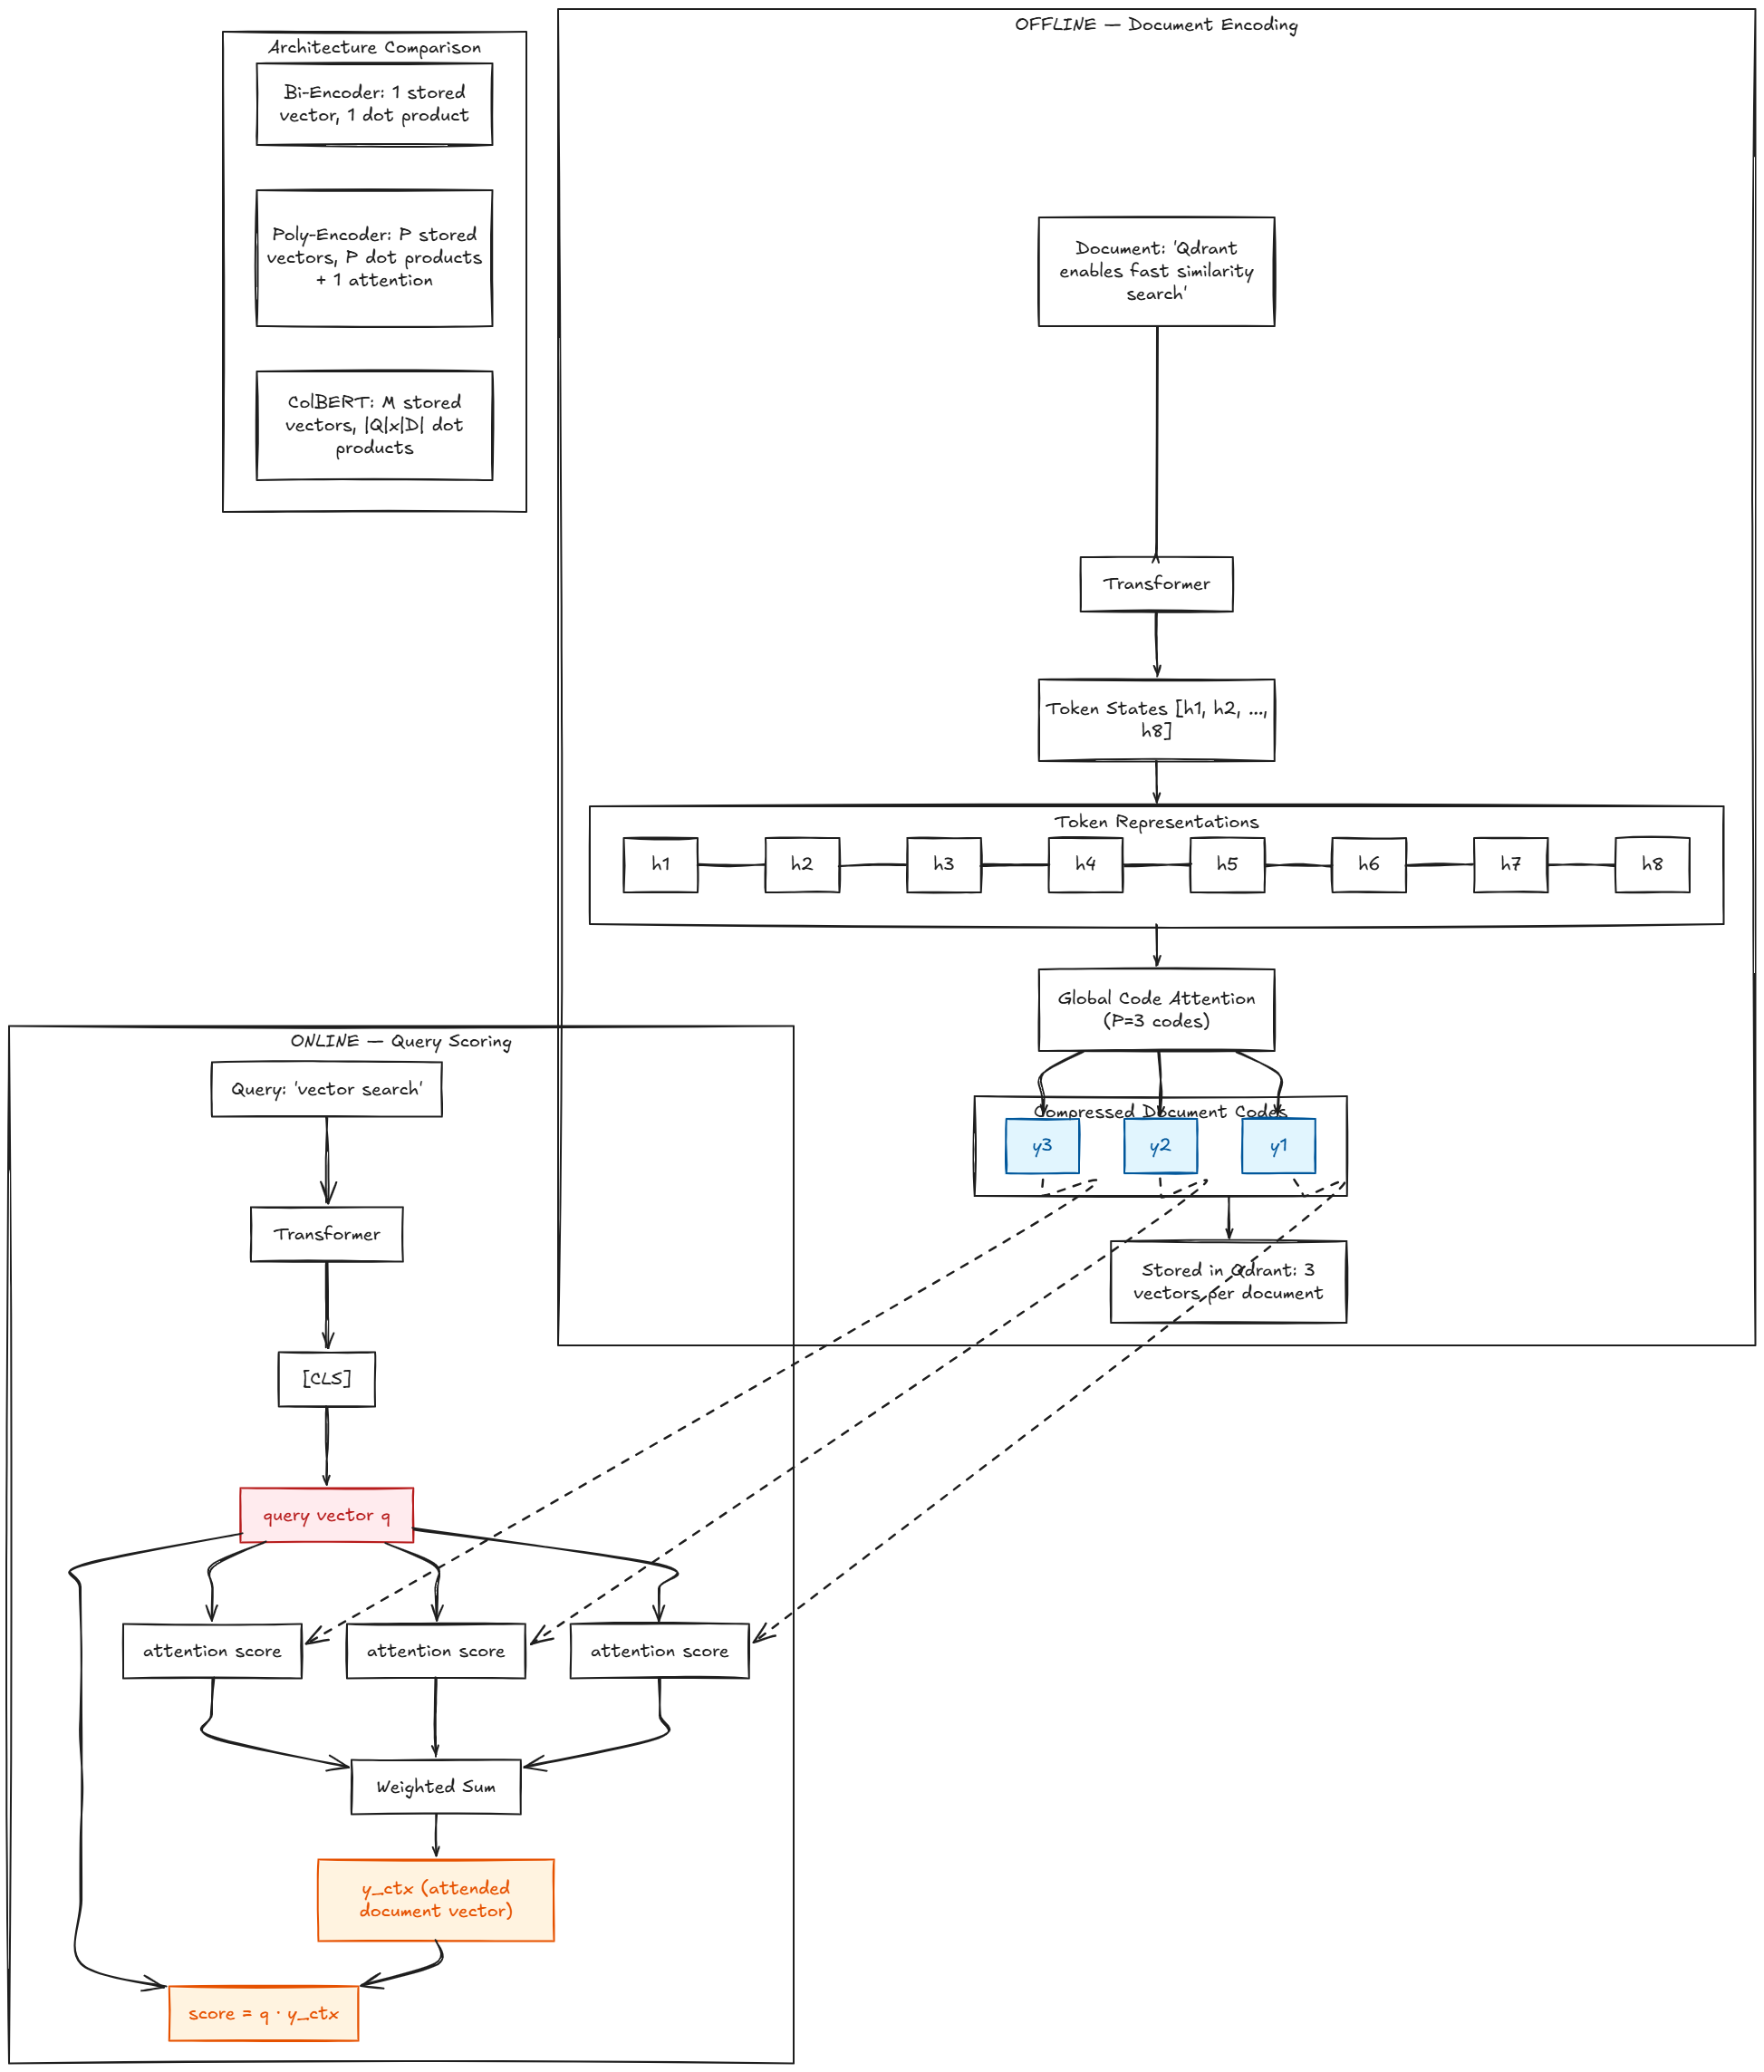

---
<a id='image-search'></a>
## 7. Vector-Based Image Search

### How Images Become Vectors

Text and images live in fundamentally different input spaces, but the core idea of dense retrieval is the same: **map inputs to vectors, then compare vectors.**

The two dominant approaches:

#### Approach A — Single-Modality Image Encoder
A Vision Transformer (ViT) or CNN encodes images into dense vectors:
```
Image → ViT Patch Encoder → [CLS] or Mean-Pool of patches → Image Vector ∈ ℝ^768
```
- Used for **image-to-image retrieval**: find visually similar images
- Query is also an image
- Pure visual semantics, no text understanding

#### Approach B — Cross-Modal Encoder (CLIP)
CLIP (OpenAI, 2021) trains **two separate encoders** — one for images, one for text — with a shared embedding space:
```
Image → Image Encoder → image_embedding ∈ ℝ^512
Text  → Text Encoder  → text_embedding  ∈ ℝ^512
```
Both embeddings live in the **same** latent space, aligned via contrastive training.
- Enables **text-to-image retrieval**: query = text string, results = images
- Also supports image-to-text, image-to-image

### Multi-Vector for Images

Just as with text, images can benefit from multi-vector representations:

- **Patch-level embeddings** (ViT): Each 16×16 image patch → one vector. A 224×224 image becomes 196 patch vectors.
- **Region proposals** (R-CNN-style): Object detector → crop regions → encode each region → multi-vector
- **Hierarchical features**: Store both a global scene vector AND fine-grained local vectors

In Qdrant, you can store multiple named vectors per image point:
```python
# Image point with multiple vector types
PointStruct(
    id=image_id,
    vector={
        "global": global_clip_embedding,    # 512-dim scene-level
        "patch":  patch_embeddings,          # 196 × 768-dim patch-level (multivector)
        "text":   text_description_embedding # 512-dim for text query compatibility
    }
)
```

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Code Example 6: Image Embeddings in Qdrant (with CLIP simulation)
# In production: use clip-vit-base-patch32 from openai/clip or huggingface
# Here: simulate CLIP-compatible embeddings to show the Qdrant pattern
# ─────────────────────────────────────────────────────────────────────────────

COLLECTION_IMAGE = "image_retrieval_demo"
CLIP_DIM = 512  # Standard CLIP output dimension
PATCH_DIM = 768 # ViT-Base patch embedding dimension

# Multi-named-vector collection:
# - 'clip_global': 512-dim CLIP image embedding (scene-level)
# - 'text_query': 512-dim CLIP text embedding (for text-to-image queries)
client.create_collection(
    collection_name=COLLECTION_IMAGE,
    vectors_config={
        "clip_global": VectorParams(
            size=CLIP_DIM,
            distance=Distance.COSINE
        ),
        "text_query": VectorParams(
            size=CLIP_DIM,
            distance=Distance.COSINE
        ),
    }
)

print(f"✅ Created multi-named-vector image collection: '{COLLECTION_IMAGE}'")
print(f"   'clip_global' : {CLIP_DIM}-dim CLIP image embeddings")
print(f"   'text_query'  : {CLIP_DIM}-dim CLIP text embeddings (aligned space)")

✅ Created multi-named-vector image collection: 'image_retrieval_demo'
   'clip_global' : 512-dim CLIP image embeddings
   'text_query'  : 512-dim CLIP text embeddings (aligned space)


In [ ]:
# Simulate a CLIP image encoder
# In real code: replace with clip_model.encode_image(preprocess(img))
def simulate_clip_image_embedding(image_description: str) -> np.ndarray:
    """Simulate a CLIP image embedding using text proxy for demo purposes."""
    vec = single_encoder.encode(image_description, normalize_embeddings=True)
    # Project to CLIP_DIM via random matrix (in real CLIP, this is the image encoder)
    proj = np.random.randn(SINGLE_DIM, CLIP_DIM)
    proj /= np.linalg.norm(proj, axis=0, keepdims=True)
    clipped = vec @ proj
    return clipped / (np.linalg.norm(clipped) + 1e-8)

def simulate_clip_text_embedding(text: str) -> np.ndarray:
    """Simulate a CLIP text embedding (aligned with image space)."""
    return simulate_clip_image_embedding(text)  # Same projection = aligned space

# Sample image catalog
np.random.seed(42)  # Fix projection matrix
image_catalog = [
    {"id": 0, "filename": "golden_retriever.jpg",  "description": "a golden retriever dog playing in a green park"},
    {"id": 1, "filename": "sunset_beach.jpg",       "description": "a beautiful sunset over a calm ocean beach with orange sky"},
    {"id": 2, "filename": "city_night.jpg",          "description": "city skyline at night with bright lights and reflections"},
    {"id": 3, "filename": "mountain_lake.jpg",       "description": "a serene mountain lake with snow-capped peaks reflected in water"},
    {"id": 4, "filename": "coffee_shop.jpg",         "description": "a cozy indoor coffee shop with wooden tables and warm lighting"},
    {"id": 5, "filename": "neural_network.jpg",      "description": "abstract visualization of a neural network with glowing nodes"},
    {"id": 6, "filename": "keyboard_code.jpg",       "description": "a mechanical keyboard next to a monitor showing code"},
    {"id": 7, "filename": "dog_beach.jpg",           "description": "a dog running along a sandy beach with ocean waves"},
]

# Build image points with both clip_global and text_query vectors
image_points = []
for img in image_catalog:
    img_emb  = simulate_clip_image_embedding(img["description"])
    text_emb = simulate_clip_text_embedding(img["description"])  # Pre-indexed text

    image_points.append(
        PointStruct(
            id=img["id"],
            vector={
                "clip_global": img_emb.tolist(),
                "text_query":  text_emb.tolist(),
            },
            payload={
                "filename":    img["filename"],
                "description": img["description"]
            }
        )
    )

client.upsert(collection_name=COLLECTION_IMAGE, points=image_points)
print(f"✅ Indexed {len(image_points)} images into '{COLLECTION_IMAGE}'")
print("   Each image has 2 named vectors: 'clip_global' and 'text_query'")

✅ Indexed 8 images into 'image_retrieval_demo'
   Each image has 2 named vectors: 'clip_global' and 'text_query'


In [ ]:
# Text-to-Image Retrieval (CLIP-style)
text_query = "dogs playing near water"
text_query_vec = simulate_clip_text_embedding(text_query).tolist()

# Search using the 'text_query' named vector
img_results = client.query_points(
    collection_name=COLLECTION_IMAGE,
    query=text_query_vec,
    using="text_query",
    limit=3,
    with_payload=True
).points


print(f"Text-to-Image Query: '{text_query}'")
print("-" * 70)
for rank, hit in enumerate(img_results, 1):
    print(f"Rank {rank} | Score: {hit.score:.4f} | File: {hit.payload['filename']}")
    print(f"  Description: {hit.payload['description']}")

print("\n💡 In production: replace simulate_clip_text_embedding with")
print("   the actual CLIP text encoder for real cross-modal retrieval")

Text-to-Image Query: 'dogs playing near water'
----------------------------------------------------------------------
Rank 1 | Score: 0.0517 | File: coffee_shop.jpg
  Description: a cozy indoor coffee shop with wooden tables and warm lighting
Rank 2 | Score: 0.0397 | File: mountain_lake.jpg
  Description: a serene mountain lake with snow-capped peaks reflected in water
Rank 3 | Score: 0.0390 | File: golden_retriever.jpg
  Description: a golden retriever dog playing in a green park

💡 In production: replace simulate_clip_text_embedding with
   the actual CLIP text encoder for real cross-modal retrieval


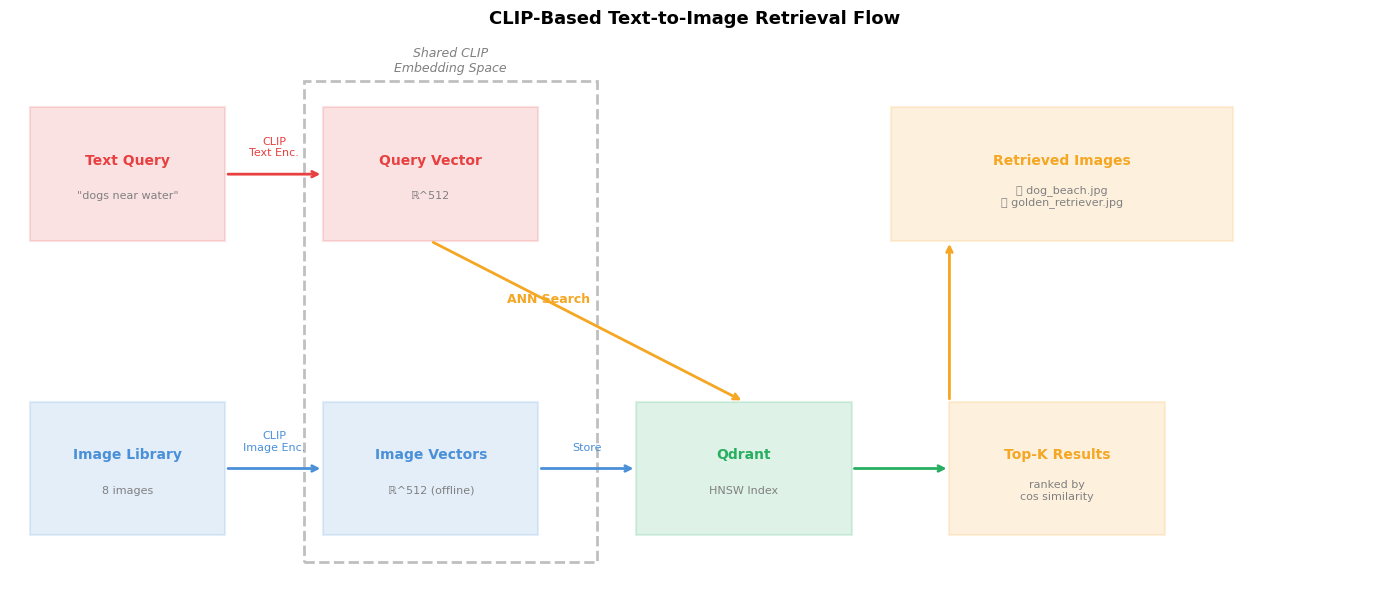

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# VISUALIZATION: Image retrieval flow diagram
# ─────────────────────────────────────────────────────────────────────────────

fig, ax = plt.subplots(figsize=(14, 6))
ax.set_xlim(0, 14); ax.set_ylim(0, 6)
ax.axis('off')
ax.set_facecolor('#F8F9FA')
ax.set_title('CLIP-Based Text-to-Image Retrieval Flow', fontsize=13, fontweight='bold', pad=15)

def draw_box(ax, x, y, w, h, label, sub='', color='#4A90D9', fontsize=10):
    rect = plt.Rectangle((x, y), w, h, linewidth=1.5, edgecolor=color,
                           facecolor=color, alpha=0.15)
    ax.add_patch(rect)
    ax.text(x + w/2, y + h/2 + (0.15 if sub else 0), label,
            ha='center', va='center', fontsize=fontsize, fontweight='bold', color=color)
    if sub:
        ax.text(x + w/2, y + h/2 - 0.25, sub,
                ha='center', va='center', fontsize=8, color='gray')

def arrow(ax, x1, y1, x2, y2, label='', color='#555'):
    ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle='->', color=color, lw=2))
    if label:
        mx, my = (x1+x2)/2, (y1+y2)/2
        ax.text(mx, my+0.2, label, ha='center', fontsize=8, color=color)

# Query flow (top)
draw_box(ax, 0.2, 3.8, 2.0, 1.5, 'Text Query', '"dogs near water"', '#E84040')
arrow(ax, 2.2, 4.55, 3.2, 4.55, 'CLIP\nText Enc.', '#E84040')
draw_box(ax, 3.2, 3.8, 2.2, 1.5, 'Query Vector', 'ℝ^512', '#E84040')

# Index flow (bottom)
draw_box(ax, 0.2, 0.5, 2.0, 1.5, 'Image Library', '8 images', '#4A90D9')
arrow(ax, 2.2, 1.25, 3.2, 1.25, 'CLIP\nImage Enc.', '#4A90D9')
draw_box(ax, 3.2, 0.5, 2.2, 1.5, 'Image Vectors', 'ℝ^512 (offline)', '#4A90D9')
arrow(ax, 5.4, 1.25, 6.4, 1.25, 'Store', '#4A90D9')
draw_box(ax, 6.4, 0.5, 2.2, 1.5, 'Qdrant', 'HNSW Index', '#27AE60')

# Both point to Qdrant
ax.annotate('', xy=(7.5, 2.0), xytext=(4.3, 3.8),
            arrowprops=dict(arrowstyle='->', color='#F5A623', lw=2))
ax.text(5.5, 3.1, 'ANN Search', ha='center', fontsize=9, color='#F5A623', fontweight='bold')

# Results
arrow(ax, 8.6, 1.25, 9.6, 1.25, '', '#27AE60')
draw_box(ax, 9.6, 0.5, 2.2, 1.5, 'Top-K Results', 'ranked by\ncos similarity', '#F5A623')
arrow(ax, 9.6, 2.0, 9.6, 3.8, '', '#F5A623')
draw_box(ax, 9.0, 3.8, 3.5, 1.5, 'Retrieved Images', '🐕 dog_beach.jpg\n🐕 golden_retriever.jpg', '#F5A623')

# Shared space annotation
ax.add_patch(plt.Rectangle((3.0, 0.2), 3.0, 5.4, linewidth=2,
                             edgecolor='gray', facecolor='none',
                             linestyle='dashed', alpha=0.5))
ax.text(4.5, 5.7, 'Shared CLIP\nEmbedding Space', ha='center', fontsize=9,
        color='gray', style='italic')

plt.tight_layout()
plt.savefig('/tmp/image_retrieval_flow.png', dpi=120, bbox_inches='tight')
plt.show()

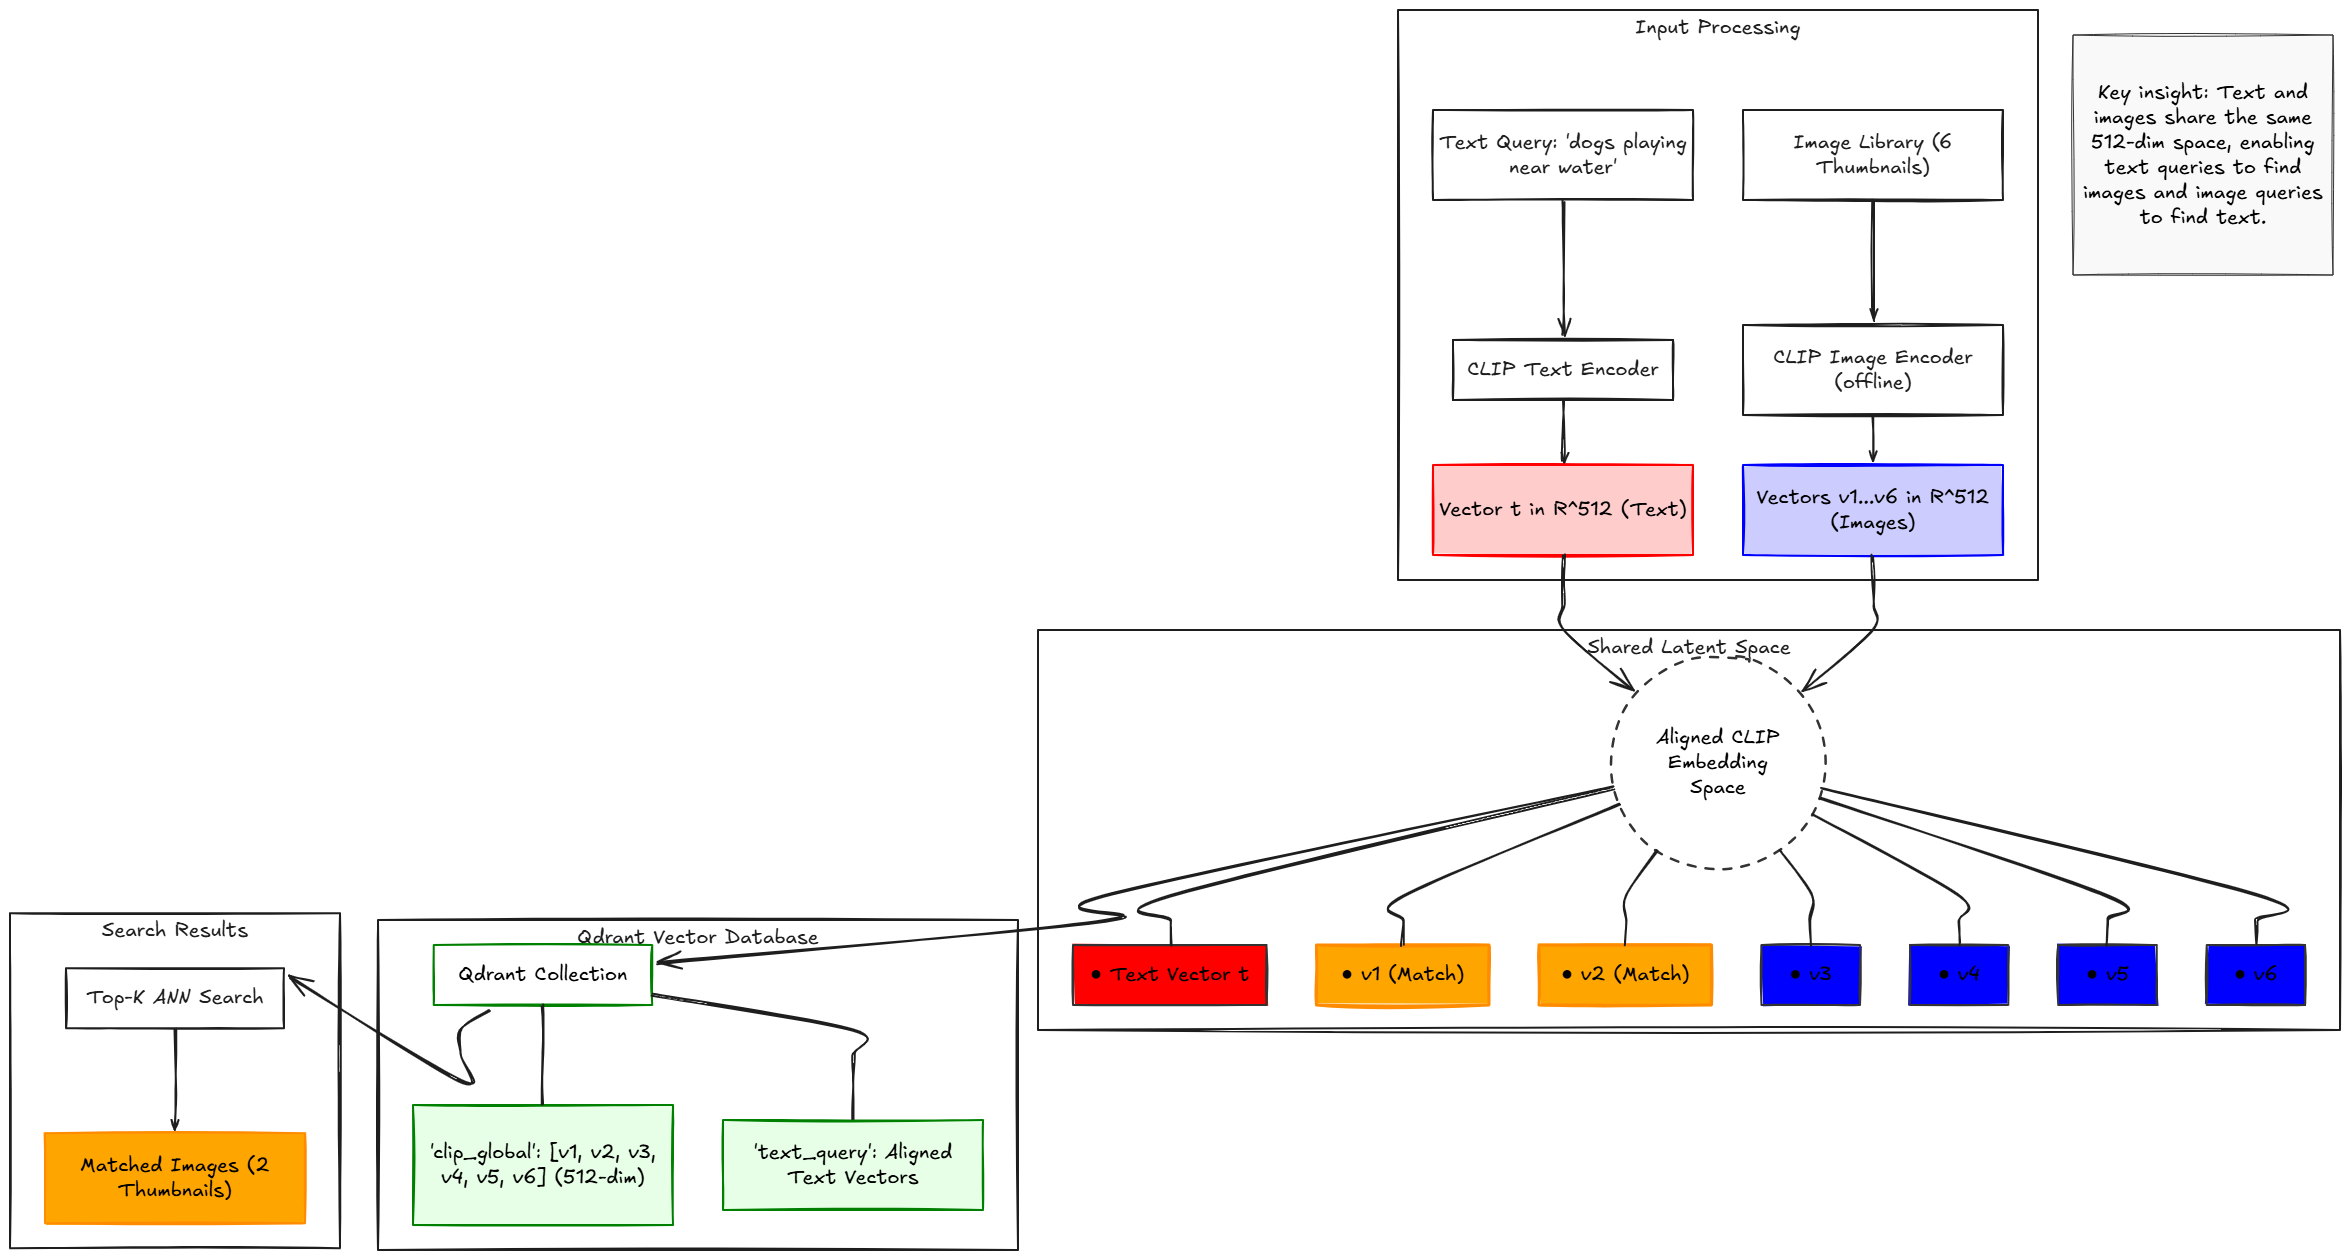
---
<a id='comparison'></a>
## 8. Architectural Comparison Deep-Dive

Now let's put everything together in a comprehensive comparison. This is the mental model you should carry with you.

### The Full Architecture Spectrum

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Comprehensive Comparison Table
# ─────────────────────────────────────────────────────────────────────────────

comparison_data = {
    'Property': [
        'Doc Representation',
        'Vectors per Doc',
        'Query Representation',
        'Interaction Function',
        'Scoring Formula',
        'Index Time Cost',
        'Storage Cost',
        'Query Latency',
        'Retrieval Quality',
        'ANN Indexable?',
        'Handles Long Docs?',
        'Cross-Attention?',
        'Qdrant Native Support'
    ],
    'Bi-Encoder\n(Single-Vector)': [
        '1 point', '1', '1 point',
        'Dot product', 'q·d',
        'Low', 'Low (1×D float)',
        '~0.1-1ms', 'Good',
        '✅ Yes', '❌ Poor',
        '❌ No', '✅ Basic vectors'
    ],
    'Multi-Vector\n(Chunking)': [
        'N points', '4-20', '1 point',
        'MaxSim / Mean', 'max(q·dᵢ)',
        'Medium', 'Medium (N×D float)',
        '~1-5ms', 'Very Good',
        '⚠️ Partial', '✅ Good',
        '❌ No', '✅ MultiVectorConfig'
    ],
    'ColBERT\n(Late Interaction)': [
        'M token points', '50-512', 'K token points',
        'Sum of MaxSim', 'Σᵢ maxⱼ(qᵢ·dⱼ)',
        'High', 'High (M×D float)',
        '~5-50ms', 'Excellent',
        '⚠️ With PLAID', '✅ Excellent',
        '✅ Token-level', '✅ MultiVectorConfig'
    ],
    'Poly-Encoder': [
        'P code points', '16-64', '1 point + attention',
        'Code attention', 'q·attend(q,{yᵢ})',
        'High', 'Medium (P×D float)',
        '~1-10ms', 'Excellent',
        '⚠️ Partial', '✅ Good',
        '✅ Code-level', '⚠️ Manual impl.'
    ],
    'CLIP\n(Image)': [
        '1-N points', '1 or N patches', '1 point',
        'Dot product', 'q·v (cross-modal)',
        'Low-Medium', 'Low-High (modal)',
        '~1-5ms', 'Very Good',
        '✅ Yes', 'N/A (images)',
        '❌ No', '✅ Named vectors'
    ]
}

df = pd.DataFrame(comparison_data)
df = df.set_index('Property')

print("Architectural Comparison Matrix")
print("=" * 100)
print(df.to_string())

Architectural Comparison Matrix
                      Bi-Encoder\n(Single-Vector) Multi-Vector\n(Chunking) ColBERT\n(Late Interaction)         Poly-Encoder      CLIP\n(Image)
Property                                                                                                                                      
Doc Representation                        1 point                 N points              M token points        P code points         1-N points
Vectors per Doc                                 1                     4-20                      50-512                16-64     1 or N patches
Query Representation                      1 point                  1 point              K token points  1 point + attention            1 point
Interaction Function                  Dot product            MaxSim / Mean               Sum of MaxSim       Code attention        Dot product
Scoring Formula                               q·d                max(q·dᵢ)              Σᵢ maxⱼ(qᵢ·dⱼ)     q·a

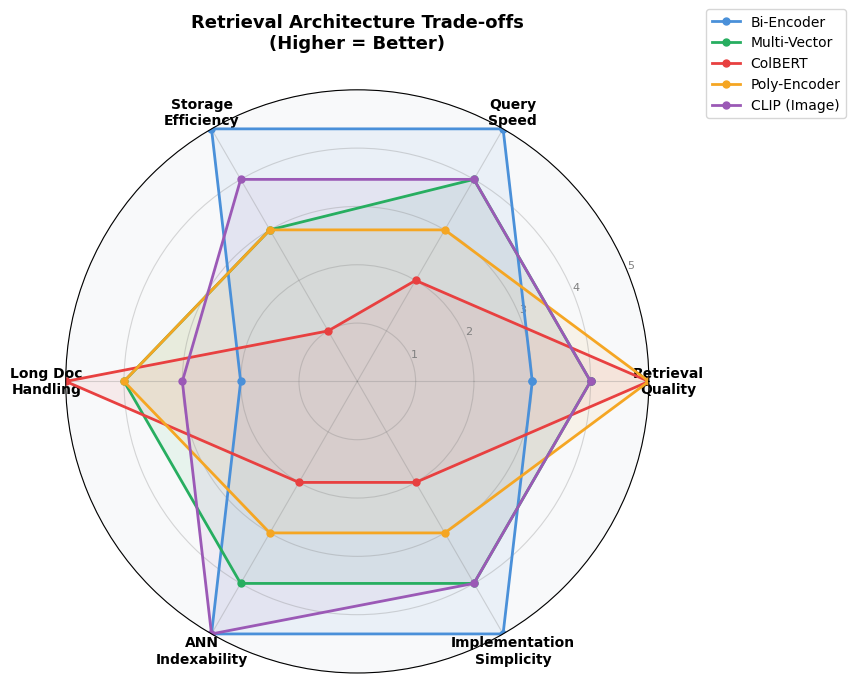

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# VISUALIZATION: Quality-Speed-Storage trade-off radar chart
# ─────────────────────────────────────────────────────────────────────────────

from matplotlib.patches import FancyBboxPatch
from matplotlib.lines import Line2D

categories = ['Retrieval\nQuality', 'Query\nSpeed', 'Storage\nEfficiency',
              'Long Doc\nHandling', 'ANN\nIndexability', 'Implementation\nSimplicity']
N = len(categories)

# Scores 1-5 (higher = better)
scores = {
    'Bi-Encoder':   [3, 5, 5, 2, 5, 5],
    'Multi-Vector': [4, 4, 3, 4, 4, 4],
    'ColBERT':      [5, 2, 1, 5, 2, 2],
    'Poly-Encoder': [5, 3, 3, 4, 3, 3],
    'CLIP (Image)': [4, 4, 4, 3, 5, 4],
}

colors_radar = ['#4A90D9', '#27AE60', '#E84040', '#F5A623', '#9B59B6']

angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # complete the circle

fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(polar=True))
ax.set_facecolor('#F8F9FA')

for (method, score), color in zip(scores.items(), colors_radar):
    vals = score + score[:1]
    ax.plot(angles, vals, 'o-', linewidth=2, color=color, label=method, markersize=5)
    ax.fill(angles, vals, alpha=0.08, color=color)

# Labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=10, fontweight='bold')
ax.set_ylim(0, 5)
ax.set_yticks([1, 2, 3, 4, 5])
ax.set_yticklabels(['1', '2', '3', '4', '5'], size=8, color='gray')
ax.grid(color='gray', alpha=0.3)

ax.set_title('Retrieval Architecture Trade-offs\n(Higher = Better)',
             pad=30, fontsize=13, fontweight='bold')
ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1.15), fontsize=10)

plt.tight_layout()
plt.savefig('/tmp/radar_comparison.png', dpi=120, bbox_inches='tight')
plt.show()

---
<a id='qdrant'></a>
## 9. Qdrant: Modeling Each Architecture

Let's consolidate what we've learned into the definitive guide for mapping each retrieval architecture to a Qdrant collection design.

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# REFERENCE: Complete Qdrant Collection Patterns
# ─────────────────────────────────────────────────────────────────────────────

print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║         QDRANT COLLECTION DESIGN PATTERNS — CHEATSHEET                      ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  1. SINGLE-VECTOR (Bi-Encoder)                                               ║
║  ─────────────────────────────────────────────────────────────────────────  ║
║  vectors_config=VectorParams(size=384, distance=Distance.COSINE)             ║
║  Point: PointStruct(id=n, vector=[...384 floats...])                         ║
║  Query: client.search(query_vector=[...384 floats...])                       ║
║                                                                              ║
║  2. MULTI-VECTOR / COLBERT (MaxSim)                                          ║
║  ─────────────────────────────────────────────────────────────────────────  ║
║  vectors_config=VectorParams(                                                ║
║      size=384, distance=Distance.COSINE,                                     ║
║      multivector_config=MultiVectorConfig(                                   ║
║          comparator=MultiVectorComparator.MAX_SIM))                          ║
║  Point: PointStruct(id=n, vector=[[v1], [v2], ..., [vN]])  ← list of lists  ║
║  Query: client.search(query_vector=[[q1], [q2], ..., [qK]])                  ║
║                                                                              ║
║  3. NAMED MULTI-VECTOR (multiple vector spaces per point)                    ║
║  ─────────────────────────────────────────────────────────────────────────  ║
║  vectors_config={                                                            ║
║      "text":  VectorParams(size=384, distance=Distance.COSINE),              ║
║      "image": VectorParams(size=512, distance=Distance.COSINE),              ║
║  }                                                                           ║
║  Point: PointStruct(id=n, vector={"text": [...], "image": [...]})            ║
║  Query: client.search(query_vector=NamedVector(name="image", vector=[...]))  ║
║                                                                              ║
║  4. POLY-ENCODER (manual — P named vectors or multi-vector)                  ║
║  ─────────────────────────────────────────────────────────────────────────  ║
║  Option A: Store P code vectors as a multivector point (MaxSim scoring)      ║
║  Option B: Custom scoring at query time (fetch + re-rank)                    ║
║                                                                              ║
╚══════════════════════════════════════════════════════════════════════════════╝
""")


╔══════════════════════════════════════════════════════════════════════════════╗
║         QDRANT COLLECTION DESIGN PATTERNS — CHEATSHEET                      ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  1. SINGLE-VECTOR (Bi-Encoder)                                               ║
║  ─────────────────────────────────────────────────────────────────────────  ║
║  vectors_config=VectorParams(size=384, distance=Distance.COSINE)             ║
║  Point: PointStruct(id=n, vector=[...384 floats...])                         ║
║  Query: client.search(query_vector=[...384 floats...])                       ║
║                                                                              ║
║  2. MULTI-VECTOR / COLBERT (MaxSim)                                          ║
║  ─────────────────────────────────────────────────────────────────────────  ║
║  vectors_config=VectorParams

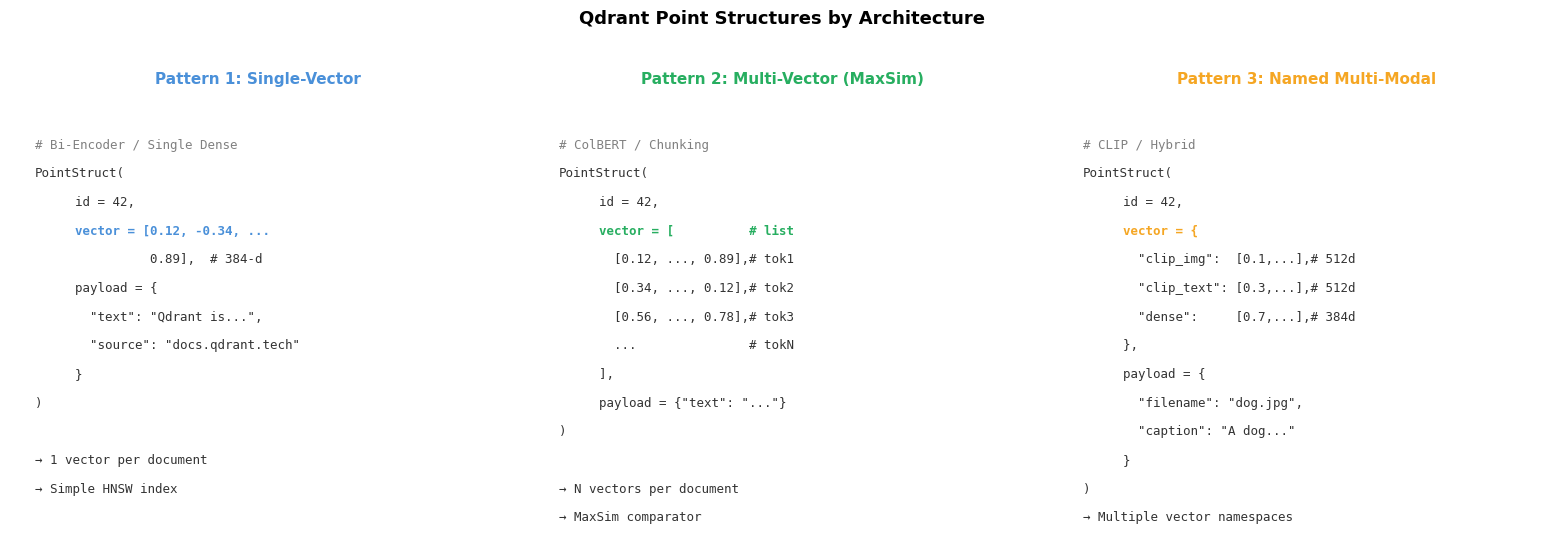

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# VISUALIZATION: Qdrant data model visualization
# ─────────────────────────────────────────────────────────────────────────────

fig, axes = plt.subplots(1, 3, figsize=(16, 6))
fig.suptitle('Qdrant Point Structures by Architecture', fontsize=13, fontweight='bold')

for ax in axes:
    ax.axis('off')
    ax.set_facecolor('white')

def draw_qdrant_point(ax, title, structure_lines, color='#4A90D9'):
    ax.set_title(title, fontsize=11, fontweight='bold', color=color, pad=10)
    y = 0.85
    for line in structure_lines:
        indent = line.startswith('  ')
        style = dict(fontsize=9, ha='left', va='center', transform=ax.transAxes,
                     fontfamily='monospace')
        if line.strip().startswith('#'):
            style['color'] = 'gray'
        elif line.strip().startswith('vector'):
            style['color'] = color
            style['fontweight'] = 'bold'
        else:
            style['color'] = '#333'
        ax.text(0.05 + (0.05 if indent else 0), y, line, **style)
        y -= 0.09

draw_qdrant_point(axes[0], 'Pattern 1: Single-Vector', [
    '# Bi-Encoder / Single Dense',
    'PointStruct(',
    '  id = 42,',
    '  vector = [0.12, -0.34, ...',
    '            0.89],  # 384-d',
    '  payload = {',
    '    "text": "Qdrant is...",',
    '    "source": "docs.qdrant.tech"',
    '  }',
    ')',
    '',
    '→ 1 vector per document',
    '→ Simple HNSW index',
], '#4A90D9')

draw_qdrant_point(axes[1], 'Pattern 2: Multi-Vector (MaxSim)', [
    '# ColBERT / Chunking',
    'PointStruct(',
    '  id = 42,',
    '  vector = [          # list',
    '    [0.12, ..., 0.89],# tok1',
    '    [0.34, ..., 0.12],# tok2',
    '    [0.56, ..., 0.78],# tok3',
    '    ...               # tokN',
    '  ],',
    '  payload = {"text": "..."}',
    ')',
    '',
    '→ N vectors per document',
    '→ MaxSim comparator',
], '#27AE60')

draw_qdrant_point(axes[2], 'Pattern 3: Named Multi-Modal', [
    '# CLIP / Hybrid',
    'PointStruct(',
    '  id = 42,',
    '  vector = {',
    '    "clip_img":  [0.1,...],# 512d',
    '    "clip_text": [0.3,...],# 512d',
    '    "dense":     [0.7,...],# 384d',
    '  },',
    '  payload = {',
    '    "filename": "dog.jpg",',
    '    "caption": "A dog..."',
    '  }',
    ')',
    '→ Multiple vector namespaces',
], '#F5A623')

for ax in axes:
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.5)
    ax.set_xticks([]); ax.set_yticks([])

plt.tight_layout(pad=2)
plt.savefig('/tmp/qdrant_patterns.png', dpi=120, bbox_inches='tight')
plt.show()

---
<a id='summary'></a>
## 10. Summary & What's Next

### What We Covered in Part 1

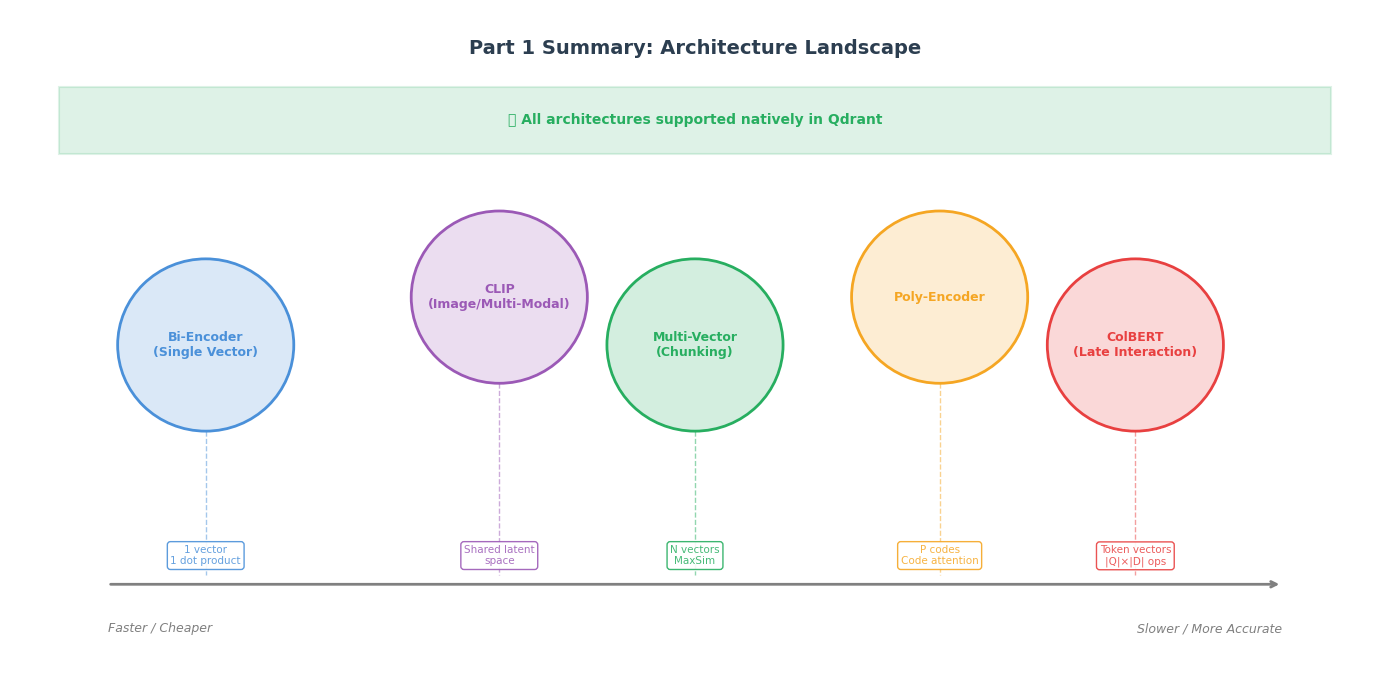

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# Final Summary Visualization
# ─────────────────────────────────────────────────────────────────────────────

fig, ax = plt.subplots(figsize=(14, 7))
ax.set_xlim(0, 14); ax.set_ylim(0, 7)
ax.axis('off')
ax.set_facecolor('#FAFAFA')

title = ax.text(7, 6.6, 'Part 1 Summary: Architecture Landscape', ha='center', va='center',
                fontsize=14, fontweight='bold', color='#2C3E50')

# X-axis: quality spectrum
ax.annotate('', xy=(13, 1), xytext=(1, 1),
            arrowprops=dict(arrowstyle='->', lw=2, color='gray'))
ax.text(1, 0.5, 'Faster / Cheaper', ha='left', fontsize=9, color='gray', style='italic')
ax.text(13, 0.5, 'Slower / More Accurate', ha='right', fontsize=9, color='gray', style='italic')

# Architecture bubbles on the spectrum
architectures = [
    (2.0,  3.5, 'Bi-Encoder\n(Single Vector)', 0.9, '#4A90D9'),
    (5.0,  4.0, 'CLIP\n(Image/Multi-Modal)',    0.9, '#9B59B6'),
    (7.0,  3.5, 'Multi-Vector\n(Chunking)',     0.9, '#27AE60'),
    (9.5,  4.0, 'Poly-Encoder',                  0.9, '#F5A623'),
    (11.5, 3.5, 'ColBERT\n(Late Interaction)',  0.9, '#E84040'),
]

for x, y, label, r, color in architectures:
    circle = plt.Circle((x, y), r, color=color, alpha=0.2)
    circle_border = plt.Circle((x, y), r, color=color, fill=False, lw=2)
    ax.add_patch(circle)
    ax.add_patch(circle_border)
    ax.text(x, y, label, ha='center', va='center', fontsize=9,
            fontweight='bold', color=color)
    # Connect to timeline
    ax.plot([x, x], [y-r, 1.1], '--', color=color, lw=1, alpha=0.5)

# Key characteristics below
details = [
    (2.0,  -0.2, '1 vector\n1 dot product', '#4A90D9'),
    (5.0,  -0.2, 'Shared latent\nspace', '#9B59B6'),
    (7.0,  -0.2, 'N vectors\nMaxSim', '#27AE60'),
    (9.5,  -0.2, 'P codes\nCode attention', '#F5A623'),
    (11.5, -0.2, 'Token vectors\n|Q|×|D| ops', '#E84040'),
]

for x, y, text, color in details:
    ax.text(x, y + 1.5, text, ha='center', va='center', fontsize=7.5,
            color=color, alpha=0.85,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9,
                      edgecolor=color, lw=1))

# Qdrant support banner
ax.add_patch(plt.Rectangle((0.5, 5.5), 13, 0.7, color='#27AE60', alpha=0.15, lw=1.5,
                             edgecolor='#27AE60'))
ax.text(7, 5.85, '✅ All architectures supported natively in Qdrant',
        ha='center', va='center', fontsize=10, color='#27AE60', fontweight='bold')

plt.tight_layout()
plt.savefig('/tmp/summary_landscape.png', dpi=120, bbox_inches='tight')
plt.show()

### Key Takeaways from Part 1

**1. There is no universally best architecture.** The right choice depends on your latency budget, storage constraints, document length distribution, and quality requirements.

**2. The core tension is always between representation fidelity and computation cost.** More vectors = richer representation = more storage + more dot products.

**3. ColBERT's innovation was architectural, not just empirical.** By separating encoding from interaction, it unlocked cross-encoder quality at index time while keeping query-time interaction tractable.

**4. Qdrant's `MultiVectorConfig` and named vectors** make it the natural home for all these architectures without needing separate systems.

**5. CLIP's shared latent space** is a special case of single-vector retrieval where the "magic" is in the training objective, not the architecture.

---

### Collections Created in This Notebook

| Collection | Architecture | Key Config |
|-----------|--------------|------------|
| `single_vector_demo` | Bi-Encoder | `VectorParams(size=384)` |
| `multi_vector_demo` | Multi-Vector Chunking | `MultiVectorConfig(MAX_SIM)` |
| `colbert_demo` | ColBERT-style | `MultiVectorConfig(MAX_SIM)` + token vecs |
| `image_retrieval_demo` | CLIP Multi-Modal | Named vectors: `{clip_global, text_query}` |

---

### Resources & Further Reading

- **ColBERT paper**: [Khattab & Zaharia 2020](https://arxiv.org/abs/2004.12832)
- **Poly-Encoders paper**: [Humeau et al. 2020](https://arxiv.org/abs/1905.01969)
- **CLIP paper**: [Radford et al. 2021](https://arxiv.org/abs/2103.00020)
- **Qdrant Multi-Vector Docs**: [qdrant.tech/documentation/concepts/vectors/#multivectors](https://qdrant.tech/documentation/concepts/vectors/)
- **ColBERT with Qdrant**: [qdrant.tech/articles/colbert-and-late-interaction](https://qdrant.tech/articles/colbert-and-late-interaction)
- **ragatouille** (ColBERT library): `pip install ragatouille`
- **pylate** (Modern ColBERT): `pip install pylate`

In [ ]:
print("\n✅ Part 1 Complete! All code ran successfully.")


✅ Part 1 Complete! All code ran successfully.


In [ ]:
!jupyter nbconvert --to html part1_multi_vector_retrieval.ipynb

[NbConvertApp] WARNING | pattern 'part1_multi_vector_retrieval.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=Tr